In [183]:
import pandas as pd
import numpy as np
pd.set_option('display.max_row', 150)
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
import matplotlib.pyplot as plt

from risk_measure import LabelSetting, Core
from Label_combine import data_merged
import pyfolio as pf
%matplotlib inline
import quantstats as qs
# extend pandas functionality with metrics, etc.
qs.extend_pandas()


### Portfolio performance

In [184]:
measure_1 = pd.read_csv("./measrue/measure.csv")
measure_2 = pd.read_csv("./measrue/measure_2.csv")
measure_3 = pd.read_csv("./measrue/measure_coin.csv")



In [185]:
measure_1

ID                      index  Strategy  Benchmark      target_ratio  \
0     YM_4h          Cumulative Return    0.0581     0.0581  Target_2.0_Label   
1     YM_4h                      CAGR﹪    0.0491     0.0491  Target_2.0_Label   
2     YM_4h          Volatility (ann.)   -0.0790    -0.0790  Target_2.0_Label   
3     YM_4h                     Sharpe    0.1658     0.1658  Target_2.0_Label   
4     YM_4h               Max Drawdown   -0.1462    -0.1462  Target_2.0_Label   
...     ...                        ...       ...        ...               ...   
9317  PL_8h          Volatility (ann.)   -0.1045    -0.0861  Target_4.0_Label   
9318  PL_8h                     Sharpe    1.0175     0.6067  Target_4.0_Label   
9319  PL_8h               Max Drawdown   -0.0773    -0.0731  Target_4.0_Label   
9320  PL_8h        Daily Value-at-Risk   -0.0104    -0.0087  Target_4.0_Label   
9321  PL_8h  Expected Shortfall (cVaR)   -0.0104    -0.0087  Target_4.0_Label   

        win model  
0      True    xg  
1      True    xg  
2      True    xg  
3      True    xg  
4      True    xg  
...     ...   ...  
9317  False    et  
9318   True    et  
9319  False    et  
9320  False    et  
9321  False    et  

[9322 rows x 7 columns]

In [186]:
measure_1 = measure_1[measure_1["index"] != "None"]
measure_2 = measure_2[measure_2["index"] != "None"]
measure_3 = measure_3[measure_3["index"] != "None"]

maesure = pd.concat([measure_1, measure_2, measure_3]).reset_index(drop = True)
maesure = maesure[maesure["ID"].str.endswith("4h")].reset_index(drop = True).copy()
maesure['ID'] = maesure['ID'].str.replace("_4h", '')

maesure["win"] = maesure["win"].replace("0", 0)
maesure["win"] = maesure["win"].replace("False", 0)
maesure["win"] = maesure["win"].replace("True", 1)

maesure = maesure[(maesure["ID"] != "BZ") & (maesure["ID"] != "MME") & (maesure["ID"] != "PL") &(maesure["ID"] != "NKD")].reset_index(drop = True)

maesure = maesure[maesure["model"] != "svm"].reset_index(drop = True)
maesure = maesure[maesure["model"] != "et"].reset_index(drop = True)

In [187]:
maesure[ (maesure["index"] == "Cumulative Return") & (maesure["target_ratio"] == "Target_2.0_Label")  ].groupby("ID").count()

index  Strategy  Benchmark  target_ratio  win  model
ID                                                        
ADA       3         3          3             3    3      3
BNB       5         5          5             5    5      5
BTC       5         5          5             5    5      5
CL        5         5          5             5    5      5
DOGE      4         4          4             4    4      4
ES        5         5          5             5    5      5
ETH       5         5          5             5    5      5
EW        5         5          5             5    5      5
GC        4         4          4             4    4      4
MGC       4         4          4             4    4      4
NIY       4         4          4             4    4      4
NQ        5         5          5             5    5      5
PA        5         5          5             5    5      5
RTY       5         5          5             5    5      5
SOL       3         3          3             3    3      3
UB        5         5          5             5    5      5
VX        5         5          5             5    5      5
XRP       5         5          5             5    5      5
YM        5         5          5             5    5      5

In [188]:
maesure = maesure[(maesure["ID"] != "MGC") & (maesure["ID"] != "NIY") & (maesure["ID"] != "GC")]

In [189]:
maesure["ID"].unique()

array(['YM', 'NQ', 'ES', 'PA', 'EW', 'RTY', 'UB', 'CL', 'VX', 'BTC',
       'ETH', 'DOGE', 'SOL', 'BNB', 'ADA', 'XRP'], dtype=object)

In [190]:
def return_table(table):
    t = pd.pivot_table(table.groupby(["index","target_ratio"]).sum()[["win"]].reset_index(), values='win', index=['index'], columns='target_ratio')

    t = t.reindex(index=["Cumulative Return","CAGR﹪", "Volatility (ann.)","Sharpe" ,"Daily Value-at-Risk","Expected Shortfall (cVaR)","Max Drawdown"])
    t.columns = ["0.50", "0.55", "0.60", "0.65", "0.70", "0.75", "0.80", "0.85", "0.90", "0.95", "1.00"] 
    t.rename(index={"Cumulative Return":"Return",
                        "CAGR﹪":"CAGR",
                        "Volatility (ann.)":"Volatility",
                        "Sharpe" : "Sharpe ratio",
                        "Daily Value-at-Risk" : "VaR 95%",
                        "Expected Shortfall (cVaR)" : "CVaR 95%",
                        "Max Drawdown" : "MDD"
                       },inplace=True)
    return t

In [191]:
result_YM = return_table(maesure[maesure["ID"] == "YM"])
result_NQ = return_table(maesure[maesure["ID"] == "NQ"])
result_ES = return_table(maesure[maesure["ID"] == "ES"])
result_PA = return_table(maesure[maesure["ID"] == "PA"])
result_EW = return_table(maesure[maesure["ID"] == "EW"])
result_UB = return_table(maesure[maesure["ID"] == "UB"])
result_CL = return_table(maesure[maesure["ID"] == "CL"])
result_VX = return_table(maesure[maesure["ID"] == "VX"])
result_RTY = return_table(maesure[maesure["ID"] == "RTY"])

result_BTC = return_table(maesure[maesure["ID"] == "BTC"])
result_ETH = return_table(maesure[maesure["ID"] == "ETH"])
result_DOGE = return_table(maesure[maesure["ID"] == "DOGE"])
result_SOL = return_table(maesure[maesure["ID"] == "SOL"])
result_BNB = return_table(maesure[maesure["ID"] == "BNB"])
result_ADA = return_table(maesure[maesure["ID"] == "ADA"])
result_XRP = return_table(maesure[maesure["ID"] == "XRP"])

In [192]:
return_table(maesure[maesure["ID"] == "DOGE"])

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     3     3     3     3     3     2     3     3     2     3
CAGR             3     3     3     3     3     3     2     3     3     2     3
Volatility       3     3     3     3     3     3     3     3     3     3     3
Sharpe ratio     1     2     2     2     3     1     2     3     3     2     3
VaR 95%          3     3     3     3     3     3     3     3     3     3     3
CVaR 95%         3     3     3     3     3     3     3     3     3     3     3
MDD              3     3     3     3     3     3     2     3     3     2     3

In [193]:
result_YM

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           2     3     4     4     4     4     5     3     3     3     2
CAGR             2     3     4     4     4     4     5     3     3     3     2
Volatility       5     5     5     5     4     5     5     3     4     3     4
Sharpe ratio     2     4     4     4     4     4     5     3     3     3     2
VaR 95%          5     5     5     5     4     5     5     3     4     3     4
CVaR 95%         5     5     5     5     4     5     5     3     4     3     4
MDD              2     3     3     4     3     3     3     3     5     3     2

In [194]:
result_NQ

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           1     2     2     1     2     1     1     2     3     4     2
CAGR             1     2     2     1     2     1     1     2     3     4     2
Volatility       5     5     5     5     3     5     4     4     3     4     4
Sharpe ratio     1     2     2     1     2     1     1     2     3     4     2
VaR 95%          5     5     5     5     3     5     5     5     4     4     4
CVaR 95%         5     5     5     5     3     5     5     5     4     4     4
MDD              3     2     3     1     2     1     2     2     3     5     4

In [195]:
result_ES

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           0     2     2     2     4     4     4     4     4     4     3
CAGR             0     2     2     2     4     4     4     4     4     4     3
Volatility       5     5     5     5     5     5     5     4     4     4     4
Sharpe ratio     0     2     3     2     4     4     5     4     4     4     3
VaR 95%          5     5     5     5     5     5     5     4     4     4     4
CVaR 95%         5     5     5     5     5     5     5     4     4     4     4
MDD              2     2     2     2     3     4     4     2     3     3     3

In [196]:
result_PA

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           1     2     2     2     4     5     4     5     4     5     5
CAGR             1     2     2     2     4     5     4     5     4     5     5
Volatility       5     5     5     5     5     5     5     5     5     5     4
Sharpe ratio     5     5     5     5     5     5     4     5     4     5     5
VaR 95%          5     5     5     5     5     5     5     5     5     5     4
CVaR 95%         5     5     5     5     5     5     5     5     5     5     4
MDD              5     5     5     5     5     5     5     5     4     4     5

In [197]:
result_EW

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           1     1     3     2     2     4     4     5     3     4     4
CAGR             1     1     3     2     2     4     4     5     3     4     4
Volatility       5     5     5     5     5     5     4     5     4     5     5
Sharpe ratio     1     1     3     2     2     4     4     5     3     4     4
VaR 95%          5     5     5     5     5     5     4     5     4     5     5
CVaR 95%         5     5     5     5     5     5     4     5     4     5     5
MDD              1     2     4     3     4     4     3     5     3     4     3

In [198]:
result_UB

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     3     2     3     2     2     3     3     3     2     3
CAGR             3     3     2     3     2     2     3     3     3     2     3
Volatility       5     5     5     5     5     5     5     4     4     4     5
Sharpe ratio     3     3     3     3     2     2     3     3     3     2     3
VaR 95%          5     5     5     5     5     5     5     4     5     5     5
CVaR 95%         5     5     5     5     5     5     5     4     5     5     5
MDD              3     5     3     4     4     3     4     4     3     3     3

In [199]:
result_CL

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           0     0     2     1     2     3     3     5     3     4     3
CAGR             0     0     2     1     2     3     3     5     3     4     3
Volatility       5     5     5     5     5     5     4     5     4     4     4
Sharpe ratio     1     1     2     2     3     3     3     5     3     4     3
VaR 95%          5     5     5     5     5     5     4     5     4     4     4
CVaR 95%         5     5     5     5     5     5     4     5     4     4     4
MDD              5     5     4     4     4     3     4     4     4     4     4

In [200]:
result_VX

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           1     1     0     2     2     4     1     5     2     3     2
CAGR             1     1     0     2     2     4     1     5     2     3     2
Volatility       4     5     5     4     5     4     4     4     5     4     4
Sharpe ratio     2     2     2     3     3     4     1     5     4     4     2
VaR 95%          5     5     5     4     5     4     4     4     5     4     4
CVaR 95%         5     5     5     4     5     4     4     4     5     4     4
MDD              5     2     3     4     3     2     4     3     2     5     3

In [201]:
result_RTY

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     1     1     3     3     3     4     2     3     2     2
CAGR             3     1     1     3     3     3     4     2     3     2     2
Volatility       5     5     5     5     5     5     4     4     5     5     4
Sharpe ratio     3     1     2     3     3     3     4     2     3     3     2
VaR 95%          5     5     5     5     5     5     4     4     5     5     3
CVaR 95%         5     5     5     5     5     5     4     4     5     5     3
MDD              4     2     4     4     3     3     3     2     4     4     3

In [202]:
result_BTC

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           5     5     5     4     3     2     4     4     4     4     4
CAGR             5     5     5     4     3     2     4     4     4     4     4
Volatility       5     4     4     5     5     5     5     5     5     5     5
Sharpe ratio     4     4     4     3     3     2     3     3     4     4     4
VaR 95%          5     4     4     5     5     5     5     5     5     5     5
CVaR 95%         5     4     4     5     5     5     5     5     5     5     5
MDD              5     5     4     4     4     4     3     4     5     4     5

In [203]:
result_ETH

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           4     4     4     5     5     5     4     4     3     4     0
CAGR             4     4     4     5     5     5     4     4     3     4     0
Volatility       5     5     4     5     5     5     5     5     5     5     5
Sharpe ratio     4     2     3     5     5     5     4     3     3     4     0
VaR 95%          5     5     4     5     5     5     5     5     5     5     5
CVaR 95%         5     5     4     5     5     5     5     5     5     5     5
MDD              5     5     4     5     5     5     5     5     4     5     3

In [204]:
result_SOL

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     2     1     0     2     1     1     2     3     2     3
CAGR             3     2     1     0     2     1     1     2     3     2     3
Volatility       3     3     3     3     2     3     3     3     2     2     3
Sharpe ratio     1     1     1     0     2     0     1     1     3     2     3
VaR 95%          3     3     3     3     2     3     3     3     3     2     3
CVaR 95%         3     3     3     3     2     3     3     3     3     2     3
MDD              3     3     3     3     3     3     3     3     2     2     3

In [205]:
result_BNB

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     3     4     3     2     3     2     3     3     3     2
CAGR             3     3     4     3     2     3     2     3     3     3     2
Volatility       5     5     5     4     4     4     5     5     4     4     5
Sharpe ratio     1     1     3     2     1     3     2     3     3     3     2
VaR 95%          5     5     5     4     4     4     5     5     4     5     5
CVaR 95%         5     5     5     4     4     4     5     5     4     5     5
MDD              5     4     4     3     3     4     3     4     2     3     3

In [206]:
result_ADA

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     3     3     2     2     2     2     3     1     3     2
CAGR             3     3     3     2     2     2     2     3     1     3     2
Volatility       2     2     2     2     2     2     2     3     2     3     3
Sharpe ratio     2     3     3     2     3     1     2     2     1     3     1
VaR 95%          2     2     2     2     2     2     2     3     2     3     3
CVaR 95%         2     2     2     2     2     2     2     3     2     3     3
MDD              2     2     2     2     2     2     2     3     2     3     3

In [207]:
result_XRP

0.50  0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00
index                                                                         
Return           3     3     3     5     4     4     4     3     3     4     3
CAGR             3     3     3     5     4     4     4     3     3     4     3
Volatility       5     5     5     5     5     5     5     4     5     5     5
Sharpe ratio     2     3     2     3     3     2     3     3     2     2     2
VaR 95%          5     5     5     5     5     5     5     4     5     5     5
CVaR 95%         5     5     5     5     5     5     5     4     5     5     5
MDD              5     5     5     5     5     5     3     2     3     2     4

### Graph

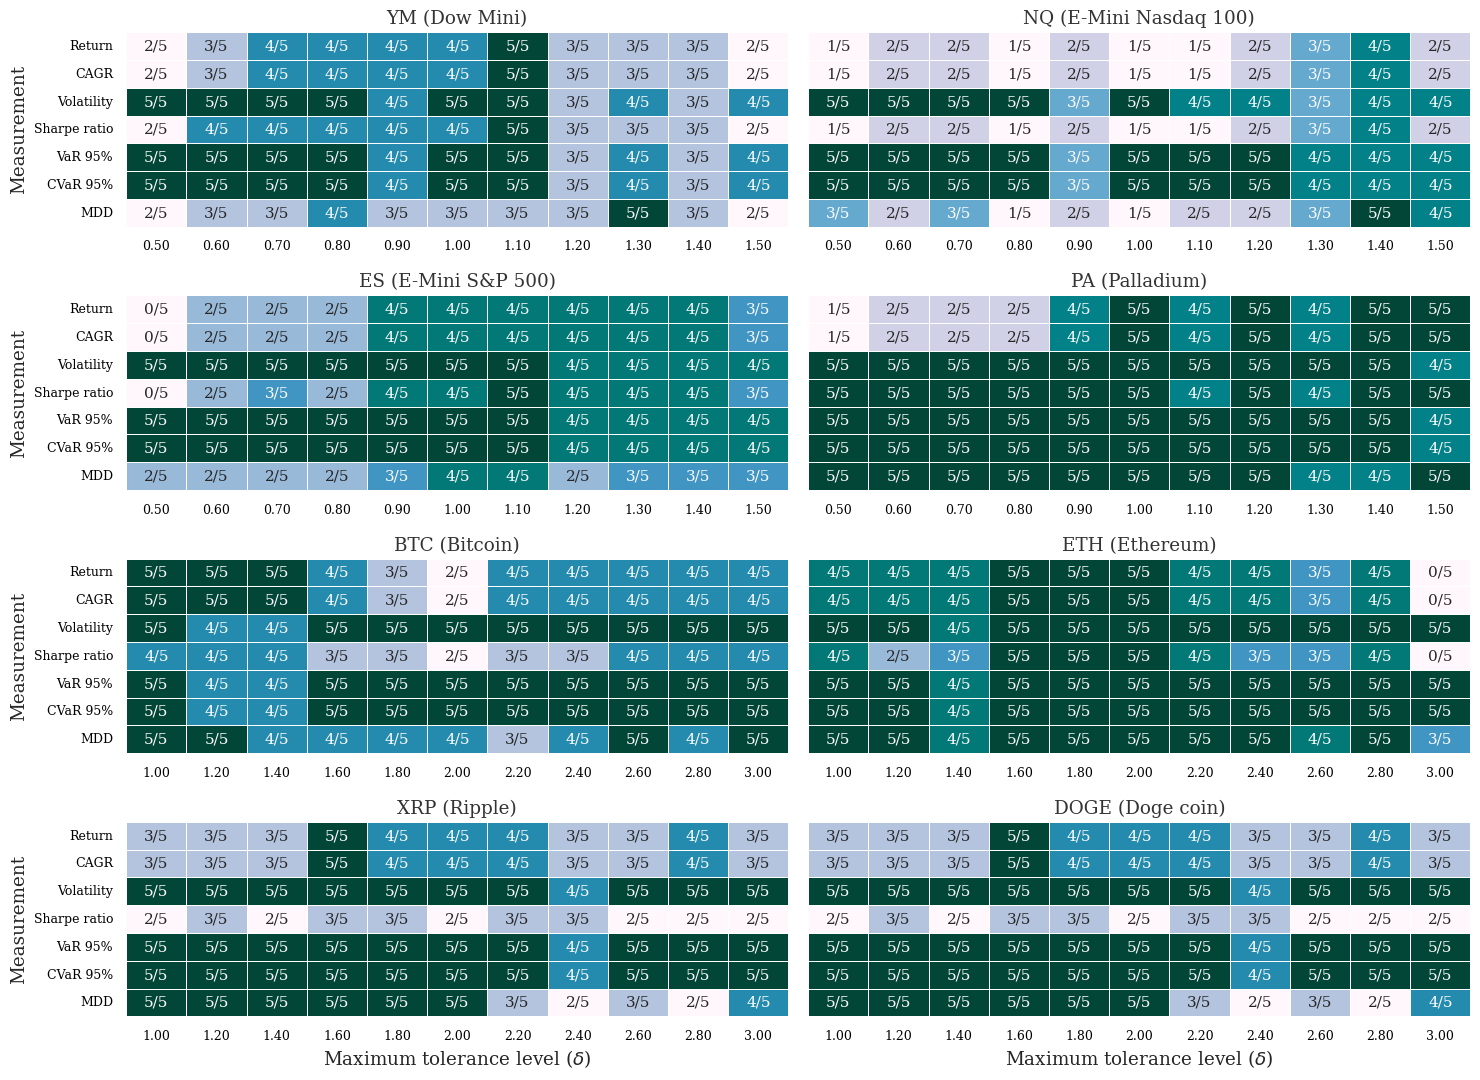

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'} , rc={"xtick.labelcolor": "black", "ytick.labelcolor": "black"})
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 9}


fig, axs = plt.subplots(ncols=2, nrows = 4, figsize=(15, 11))


g = sns.heatmap(result_YM, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("YM (Dow Mini)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_NQ, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("NQ (E-Mini Nasdaq 100)")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_ylabel(None)


g = sns.heatmap(result_ES, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ES (E-Mini S&P 500)")
g.set_xticklabels(g.get_xticklabels(), rotation = 0)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_PA, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("PA (Palladium)")
g.set_xticklabels(g.get_xticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0,fontname="DejaVu Serif")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_ylabel(None)

##################################################################################################################################

g = sns.heatmap(result_BTC, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0,fontname="DejaVu Serif")
g.set_title("BTC (Bitcoin)")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set(ylabel="Measurement")
#g.set(xlabel="Maximum tolerance level ($\delta$)")

g = sns.heatmap(result_ETH, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ETH (Ethereum)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0,fontname="DejaVu Serif")
g.set_yticklabels([])
g.set_ylabel(None)
g.tick_params(axis="x", labelsize=9, colors="black")
#g.set(xlabel="Maximum tolerance level ($\delta$)")


g = sns.heatmap(result_XRP, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("XRP (Ripple)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0,fontname="DejaVu Serif")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set(ylabel="Measurement")
g.set(xlabel="Maximum tolerance level ($\delta$)")

g = sns.heatmap(result_XRP, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3, 1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("DOGE (Doge coin)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0,fontname="DejaVu Serif")
g.set_yticklabels([])
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_ylabel(None)
g.set(xlabel="Maximum tolerance level ($\delta$)")

#####################################################################################################################################
plt.tight_layout()
plt.savefig("measure.pdf")
plt.savefig("measure.png")

#g.set_title("Similarity loss functions", fontsize  = 15)

In [48]:
### Ver 2

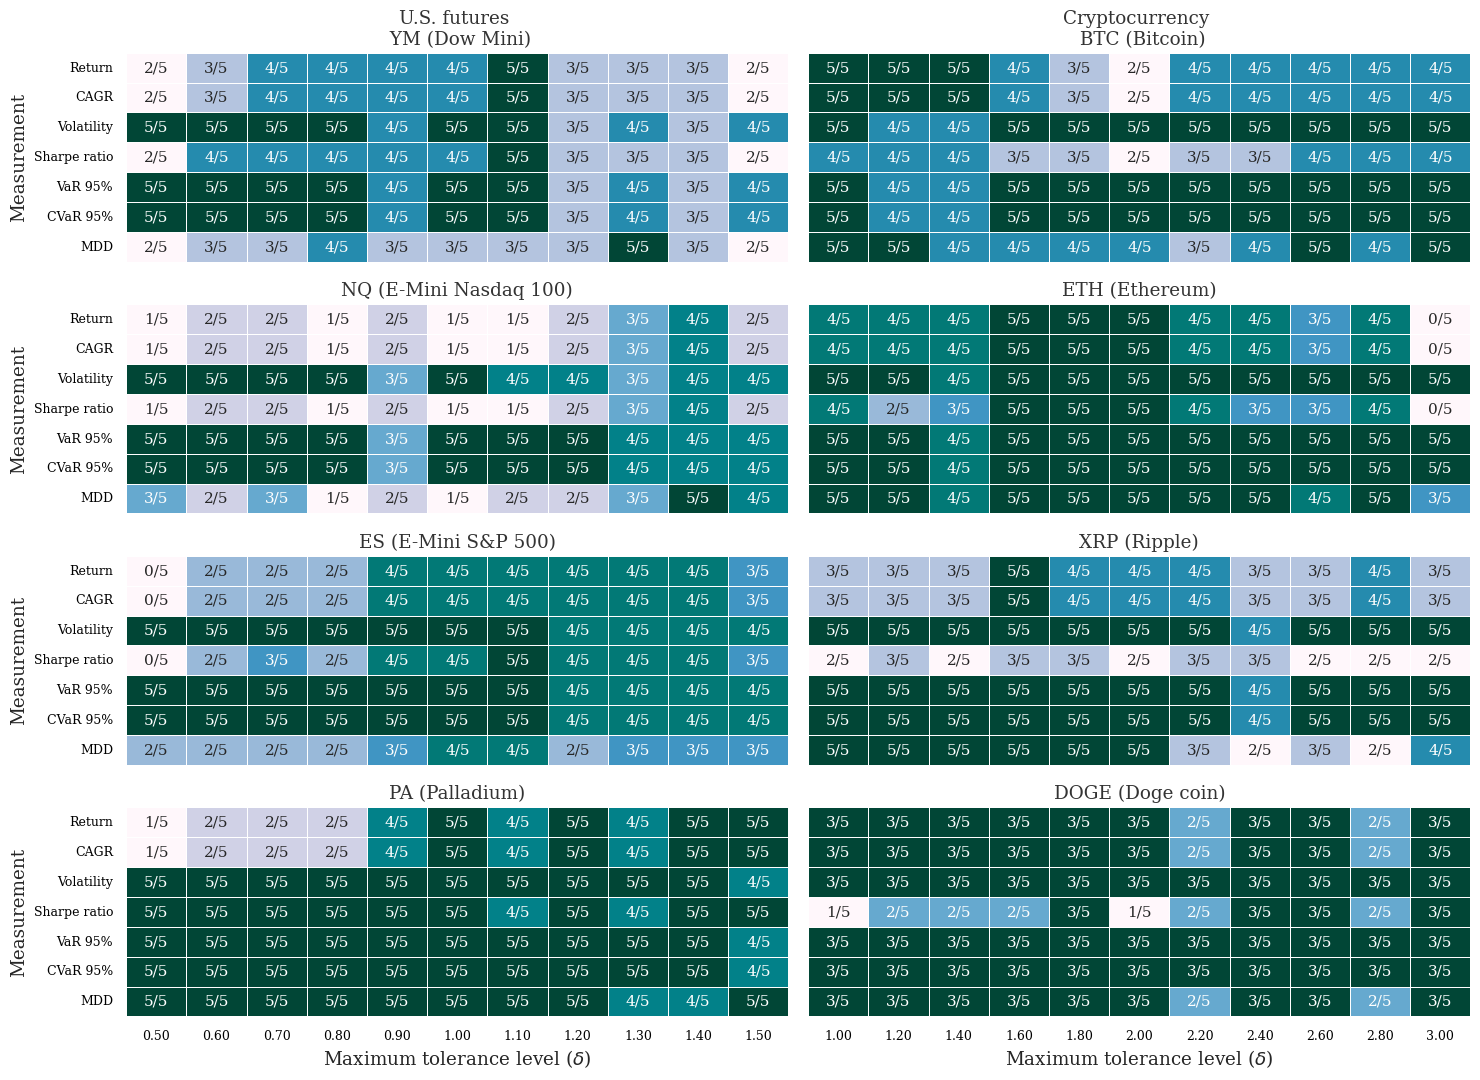

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')


#plt.rcParams['font.family'] = 'Times'
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'} , rc={"xtick.labelcolor": "black", "ytick.labelcolor": "black"})
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 9}

fig, axs = plt.subplots(ncols=2, nrows = 4, figsize=(15, 11))


g = sns.heatmap(result_YM, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("U.S. futures \n YM (Dow Mini)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels([])
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_NQ, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("NQ (E-Mini Nasdaq 100)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels([])
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")


g = sns.heatmap(result_ES, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ES (E-Mini S&P 500)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels([])
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_PA, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("PA (Palladium)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")
g.set(xlabel="Maximum tolerance level ($\delta$)")
##################################################################################################################################

g = sns.heatmap(result_BTC, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("Cryptocurrency \n BTC (Bitcoin)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels([])

g = sns.heatmap(result_ETH, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ETH (Ethereum)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels([])


g = sns.heatmap(result_XRP, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("XRP (Ripple)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels([])

g = sns.heatmap(result_DOGE, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3, 1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("DOGE (Doge coin)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.set_yticklabels([])
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_ylabel(None)
g.set(xlabel="Maximum tolerance level ($\delta$)")

#####################################################################################################################################
plt.tight_layout()
plt.savefig("measure.pdf")
plt.savefig("measure.png")

#g.set_title("Similarity loss functions", fontsize  = 15)

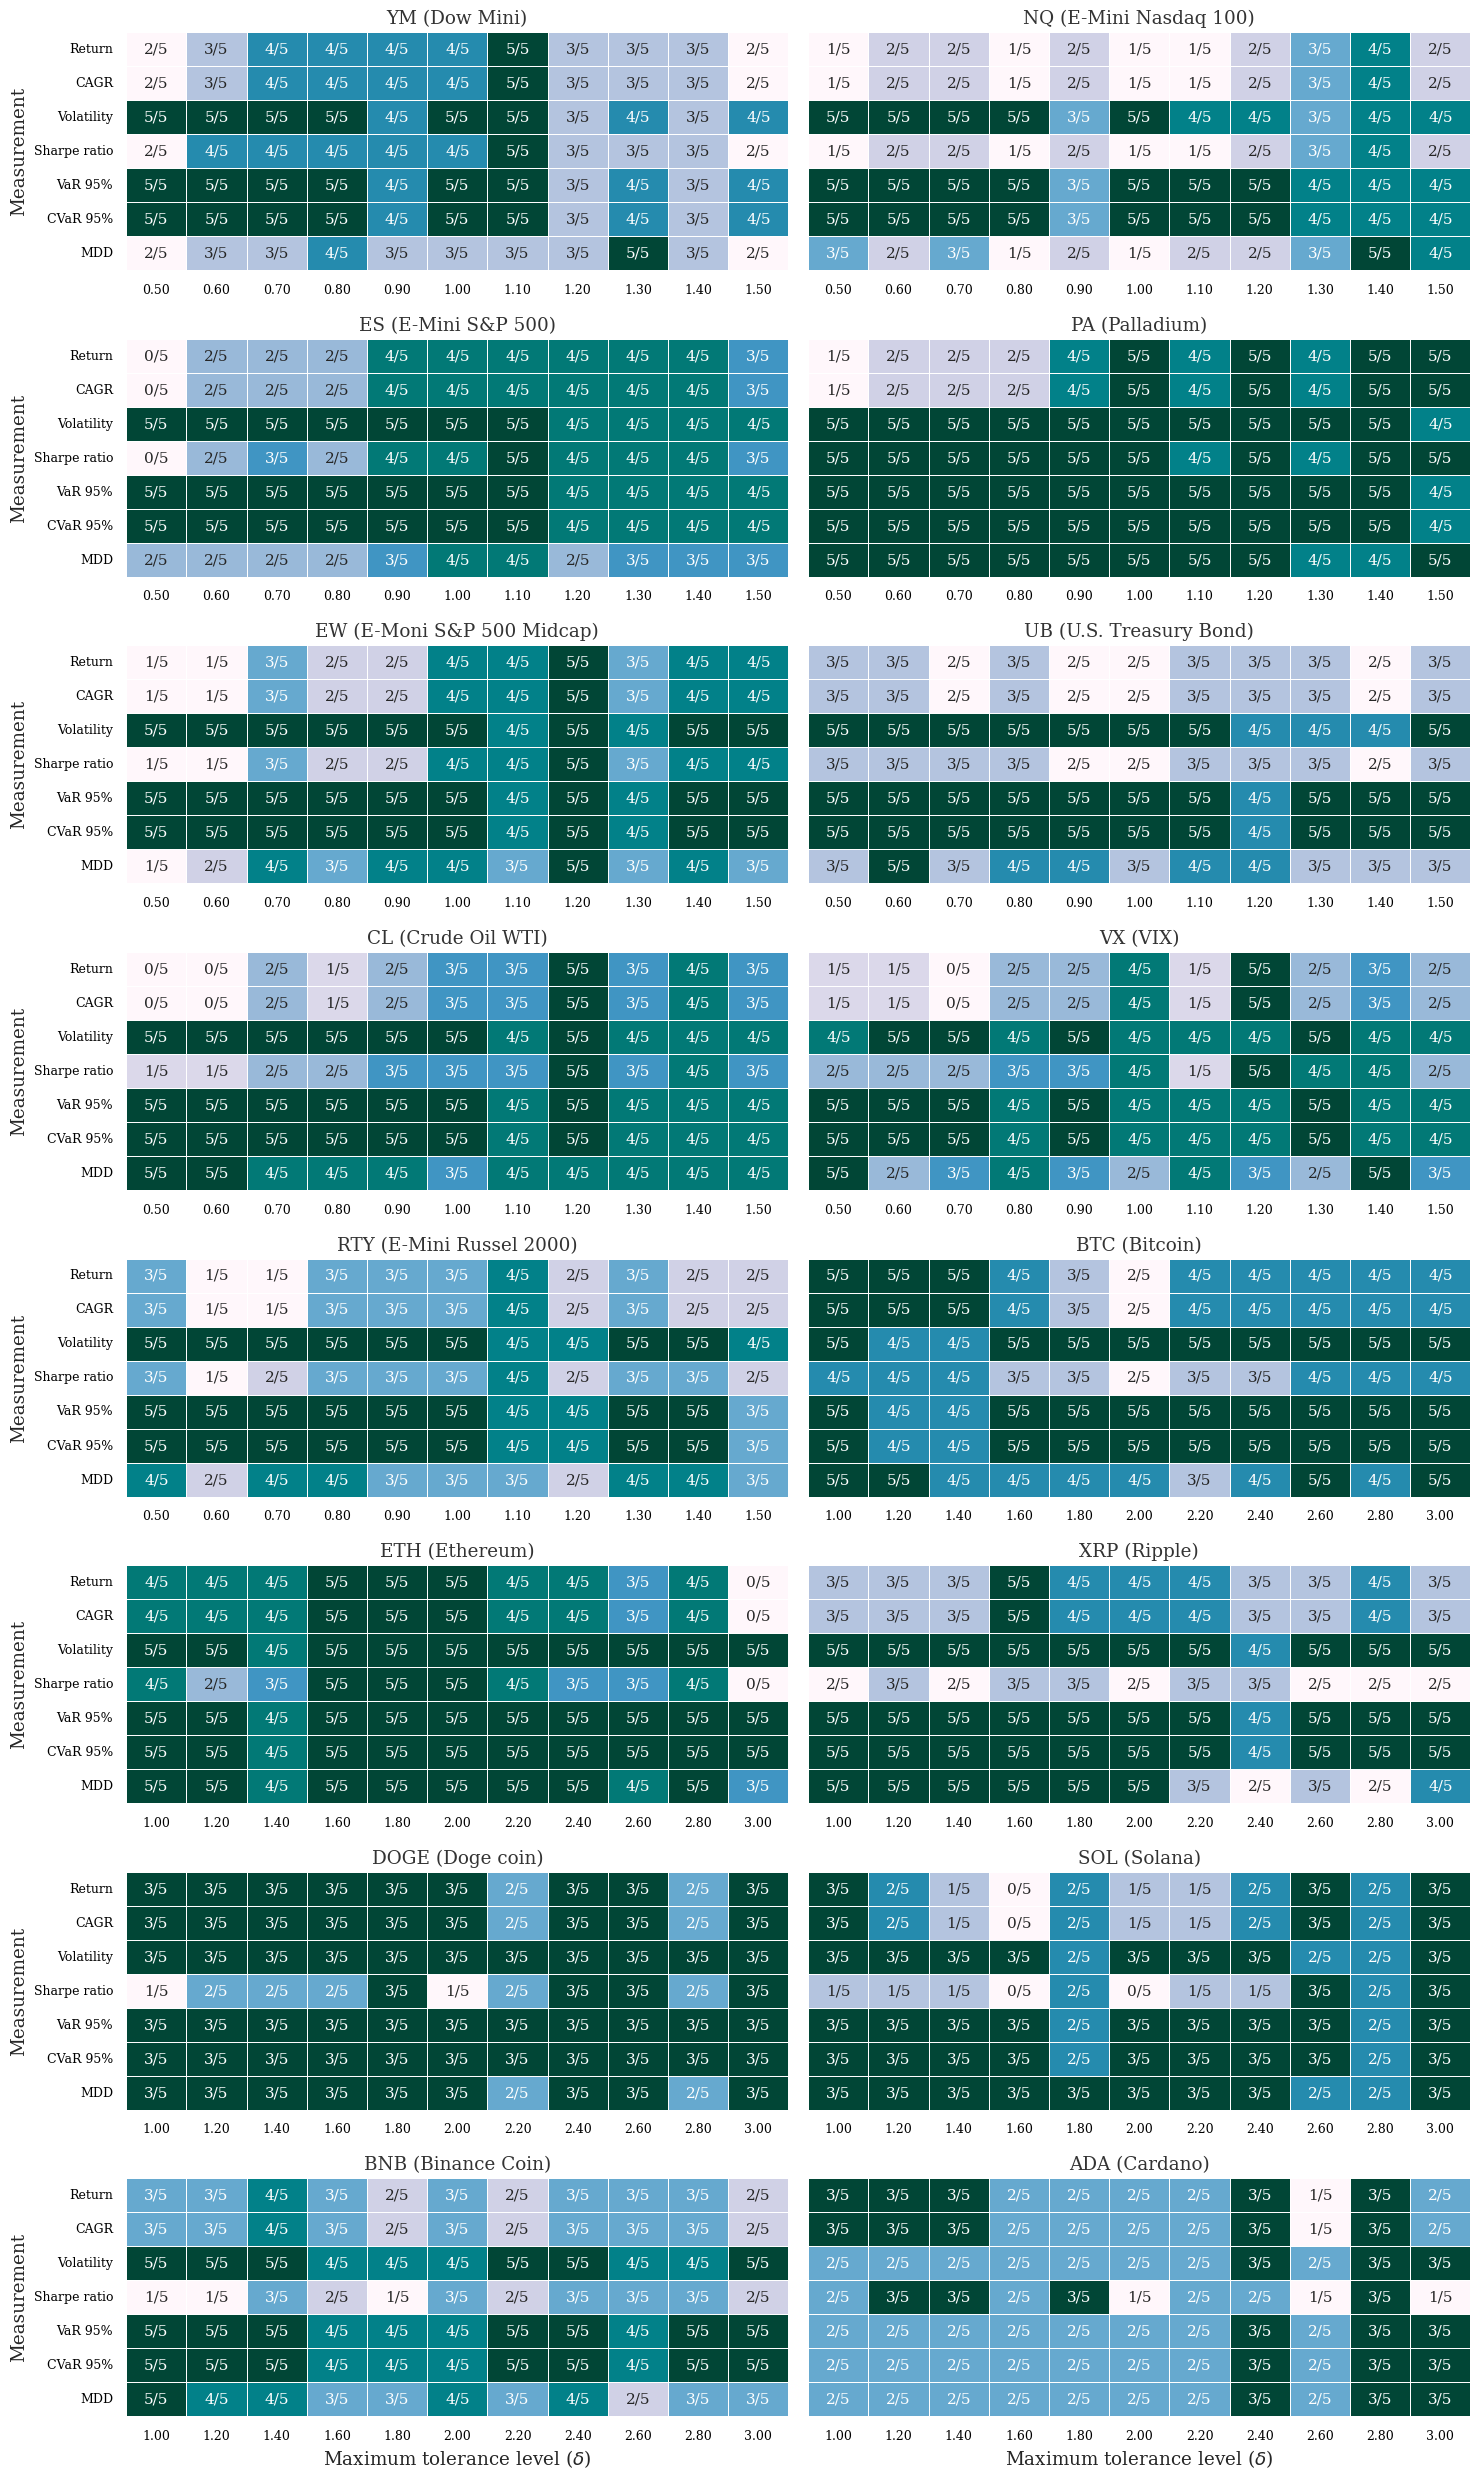

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')


#plt.rcParams['font.family'] = 'Times'
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'} , rc={"xtick.labelcolor": "black", "ytick.labelcolor": "black"})
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 9}

fig, axs = plt.subplots(ncols=2, nrows = 8, figsize=(15, 25))


g = sns.heatmap(result_YM, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("YM (Dow Mini)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_NQ, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[0,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("NQ (E-Mini Nasdaq 100)")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")

g = sns.heatmap(result_ES, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ES (E-Mini S&P 500)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")

g = sns.heatmap(result_PA, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[1,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("PA (Palladium)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_EW, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("EW (E-Moni S&P 500 Midcap)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")
g.set_xlabel(None)


g = sns.heatmap(result_UB, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[2,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("UB (U.S. Treasury Bond)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_CL, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("CL (Crude Oil WTI)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")
g.set_xlabel(None)


g = sns.heatmap(result_VX, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[3,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("VX (VIX)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")


g = sns.heatmap(result_RTY, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[4,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("RTY (E-Mini Russel 2000)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_xticklabels(['0.50','0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.20', '1.30', '1.40', '1.50'], rotation = 0, fontname="DejaVu Serif")
g.set_ylabel(None)
g.set_ylabel(None)
g.set(ylabel="Measurement")
g.set_xlabel(None)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

##################################################################################################################################

g = sns.heatmap(result_BTC, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[4,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("BTC (Bitcoin)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_ETH, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[5,0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ETH (Ethereum)")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.set(ylabel="Measurement")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_XRP, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[5,1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("XRP (Ripple)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_DOGE, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[6, 0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("DOGE (Doge coin)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="x", labelsize=9, colors="black")
g.set(ylabel="Measurement")
g.set_xlabel(None)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_SOL, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[6, 1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("SOL (Solana)")
g.set_yticklabels([])
g.set_ylabel(None)
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_BNB, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[7, 0],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("BNB (Binance Coin)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
g.tick_params(axis="x", labelsize=9, colors="black")
g.set(ylabel="Measurement")
g.set(xlabel="Maximum tolerance level ($\delta$)")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")

g = sns.heatmap(result_ADA, cmap='PuBuGn',annot=True, cbar = False, linewidths=.5,  ax = axs[7, 1],annot_kws={"size": 11}) # non _noised
for text in g.texts:
    text.set_text(text.get_text() + "/5")
g.set_title("ADA (Cardano)")
g.set_xticklabels(['1.00','1.20', '1.40', '1.60', '1.80', '2.00', '2.20', '2.40', '2.60', '2.80', '3.00'], rotation = 0)
g.set_yticklabels([])
g.tick_params(axis="x", labelsize=9, colors="black")
g.set_ylabel(None)
g.set(xlabel="Maximum tolerance level ($\delta$)")
g.tick_params(axis="y", labelsize=9, colors="black")
g.tick_params(axis="x", labelsize=9, colors="black")
#####################################################################################################################################
plt.tight_layout()
plt.savefig("all_measrue.pdf")
plt.savefig("all_measrue.png")

#g.set_title("Similarity loss functions", fontsize  = 15)

### Portfolio Plot

In [73]:
measure_1["ID"].unique()

array(['YM_4h', 'YM_8h', 'NQ_4h', 'NQ_8h', 'ES_4h', 'ES_8h', 'PA_4h',
       'PA_8h', 'EW_4h', 'EW_8h', 'RTY_4h', 'RTY_8h', 'NIY_4h', 'NIY_8h',
       'NKD_4h', 'NKD_8h', 'PL_4h', 'PL_8h'], dtype=object)

In [121]:
def get_pct_and_our_data(coin_time, model):
    
    # coin_time : RTY_4h
    # model : cat

    our_data = data_merged(result_path = "predict_result", coin_time = coin_time, model = model, origin_data = coin_time)
    our_data = pd.concat([our_data["Date"].shift(-1), our_data.iloc[:, 1:]], axis = 1).dropna().reset_index(drop = True)
    
    pct_data = LabelSetting(our_data).__GetPct__()
    
    origin_data = pd.read_csv(f"../prepro/{coin_time}.csv").iloc[:,1:5]
    origin_data = origin_data.iloc[-(pct_data.shape[0]):, :].reset_index(drop = True)
    
    return origin_data, pct_data

def return_test_model(origin_data, pct_data, traget):
    target_value = traget
    test = pd.concat([origin_data, pct_data[target_value]], axis = 1)

    test_model = pd.DataFrame(columns = ["Date", "Close"])
    test_model["Date"] = test["Date"] + " " + test["Time"]
    test_model["Close"] = test[target_value]

    test_model["Date"] = pd.DatetimeIndex(test_model["Date"])
    #test_model = test_model[test_model["Date"] >= "2021-06-20"]

    #test_model.iloc[0, 1] = np.nan
    test_model = test_model.set_index("Date")
    return test_model["Close"]

def measrue_out(data_id, model_id, target_ratio, target_ratio_benchmark):
    
    origin, pct = get_pct_and_our_data(data_id, model_id) # cat
    
    model = qs.reports.full(return_test_model(origin, pct, target_ratio), benchmark = return_test_model(origin, pct,  target_ratio_benchmark))
    return model

In [122]:
#origin, pct = get_pct_and_our_data("YM_4h","cat")
#
#return_test_model(origin, pct, "Target_3.0_Label").to_csv("./out_return/YM_30_label.csv", index = True)
#return_test_model(origin, pct, "Target_3.0post_Label").to_csv("./out_return/YM_30_post_label.csv", index = True)

In [123]:
#origin, pct = get_pct_and_our_data("YM_4h","cat")
#
#return_test_model(origin, pct, "Target_3.2_Label").to_csv("./out_return/YM_32_label.csv", index = True)
#return_test_model(origin, pct, "Target_3.2post_Label").to_csv("./out_return/YM_32_post_label.csv", index = True)

In [124]:
#origin, pct = get_pct_and_our_data("YM_4h","cat")
#
#return_test_model(origin, pct, "Target_2.8_Label").to_csv("./out_return/YM_28_label.csv", index = True)
#return_test_model(origin, pct, "Target_2.8post_Label").to_csv("./out_return/YM_28_post_label.csv", index = True)

In [125]:
def return_model(data_id, model_id, target_ratio, target_ratio_benchmark):

    origin, pct = get_pct_and_our_data(data_id, model_id) # cat

    # Define data
    dates = return_test_model(origin, pct, target_ratio).reset_index()["Date"]
    benchmark_returns = return_test_model(origin, pct, target_ratio_benchmark)
    strategy_returns = return_test_model(origin, pct, target_ratio)

    # Calculate rolling cumulative returns
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()
    strategy_cumulative_returns = (1 + strategy_returns).cumprod()
    
    return benchmark_cumulative_returns, strategy_cumulative_returns

    

In [126]:


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager


def plot_return(otrigin, pct, target_ratio, target_ratio_benchmark):
    # Define data
    dates = return_test_model(origin, pct, target_ratio).reset_index()["Date"]
    benchmark_returns = return_test_model(origin, pct, target_ratio_benchmark)
    strategy_returns =return_test_model(origin, pct, target_ratio)

    # Calculate rolling cumulative returns
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()
    strategy_cumulative_returns = (1 + strategy_returns).cumprod()

    # Plot rolling cumulative returns
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.plot(benchmark_cumulative_returns.rolling(window=20).mean(), label='Benchmark')
    ax.plot(strategy_cumulative_returns.rolling(window=20).mean(), label='Strategy')

    # Highlight a specific x-axis area with gray color
    ax.axvspan('2022-05-01 00:00:00','2022-07-01 00:00:00', alpha=0.2, color='gray')

    ax.legend()
    ax.set_title(f'$\delta$ = {target_ratio}')
    ax.set_xlabel('')
    ax.set_ylabel('BTC of cumulative Return')
    plt.show()

In [180]:
import os

In [181]:
os.getcwd()

'/data/stop/result_summary'

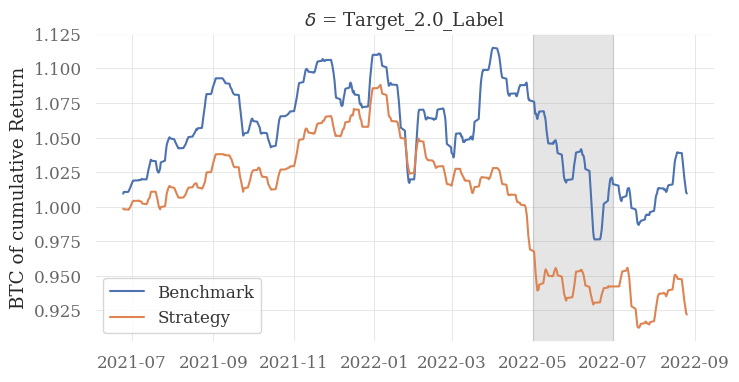

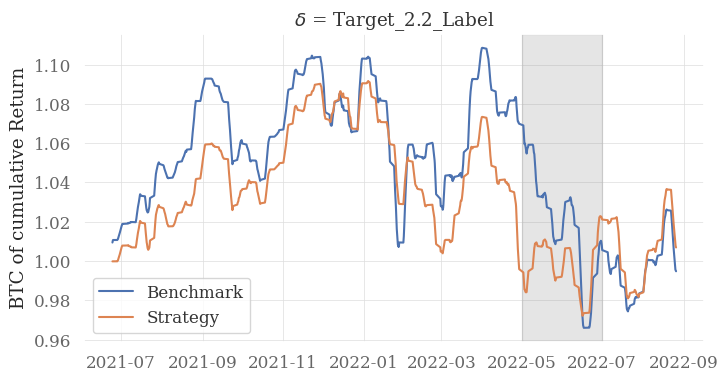

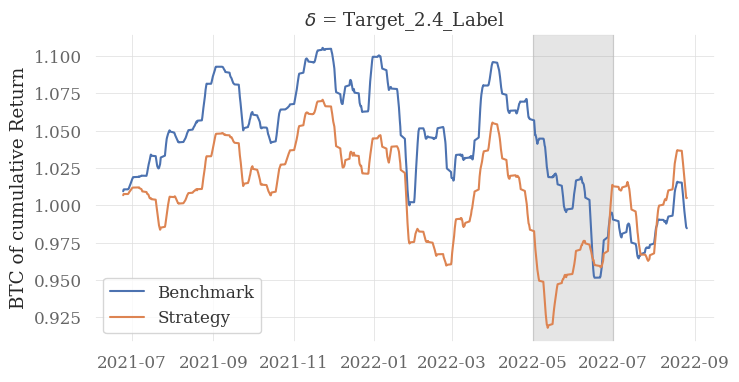

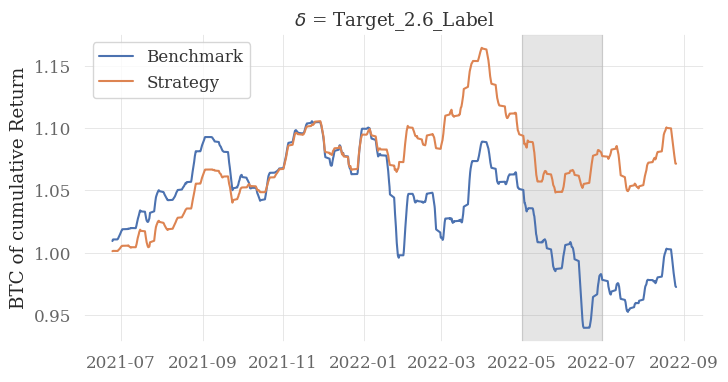

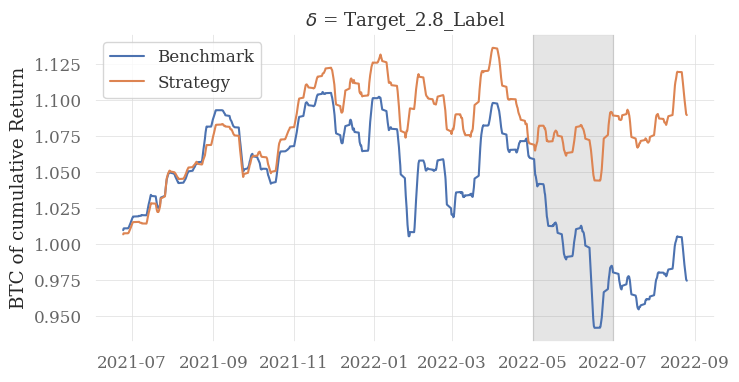

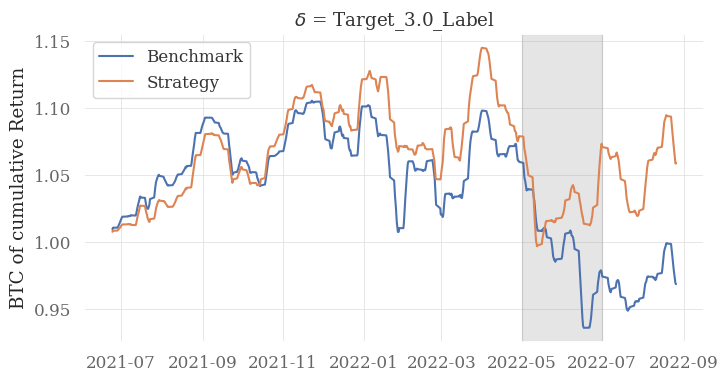

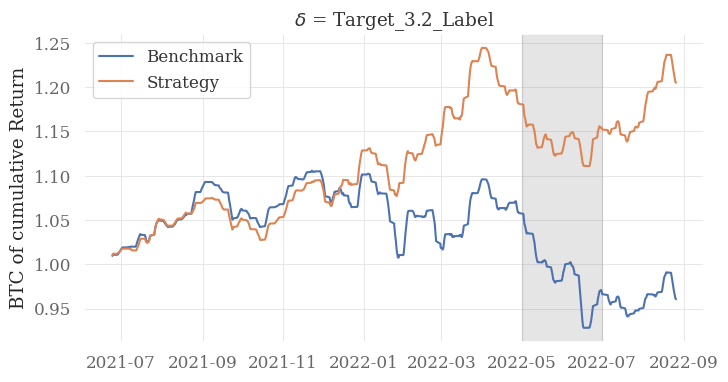

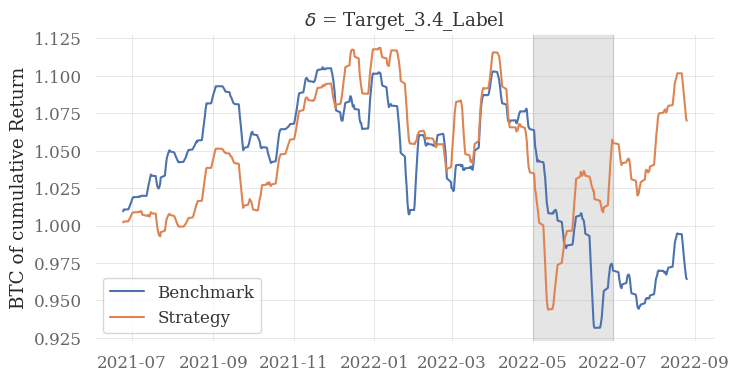

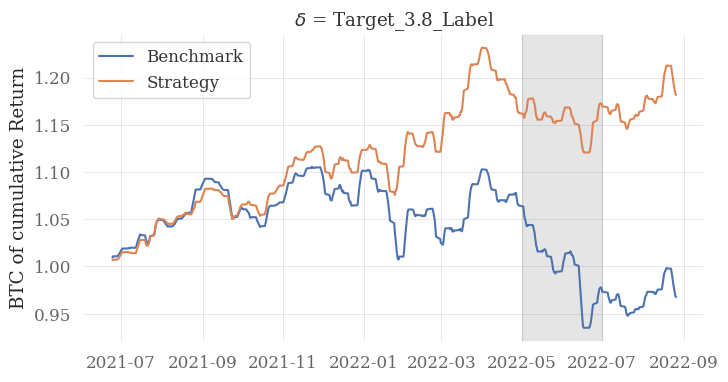

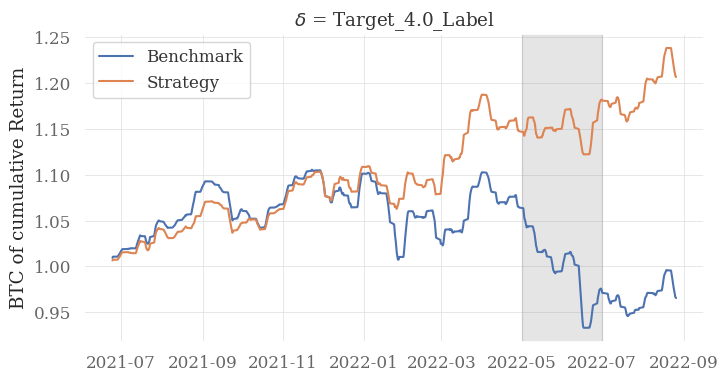

In [182]:
origin, pct = get_pct_and_our_data("ES_4h", "knn") # get_pct_and_our_data("YM_4h", "knn")  ata("NQ_4h", "knn") ("ES_4h", "knn") 
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

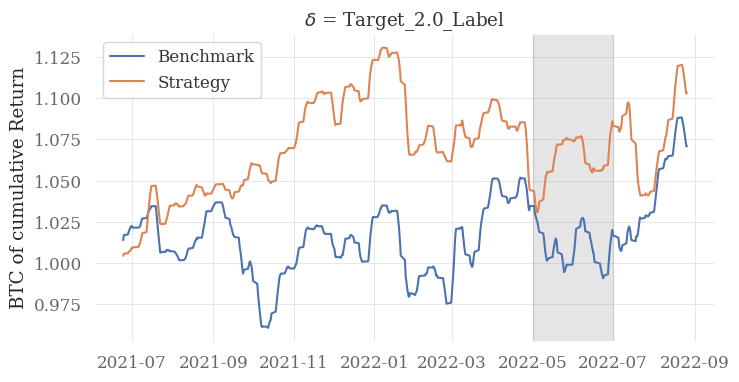

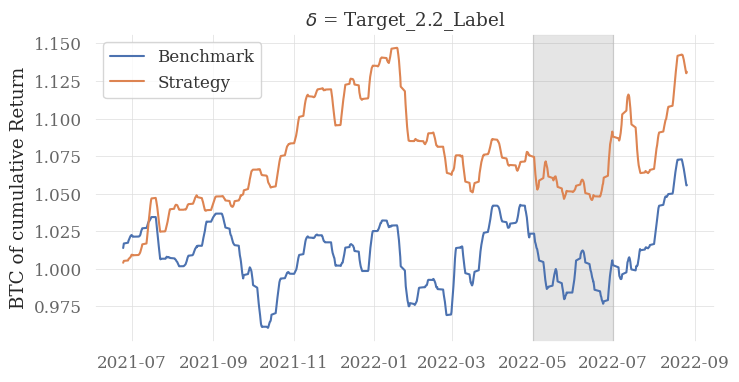

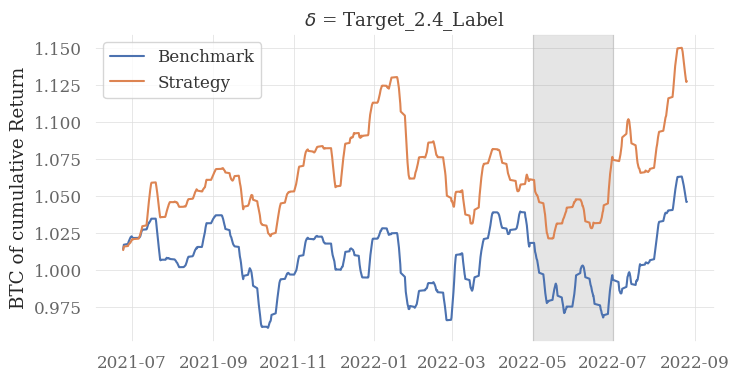

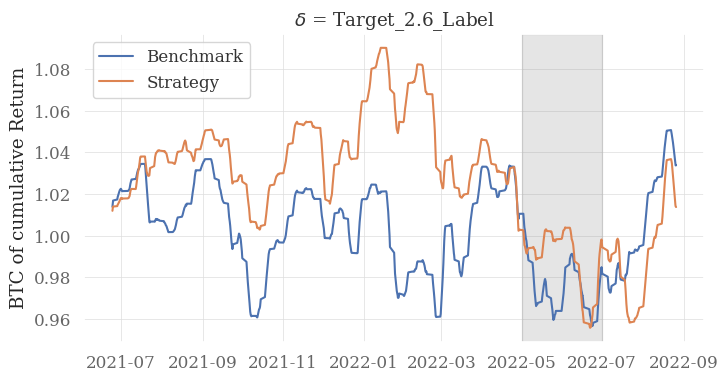

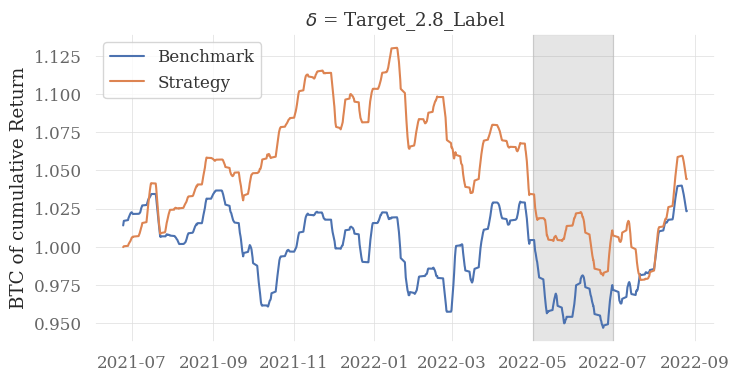

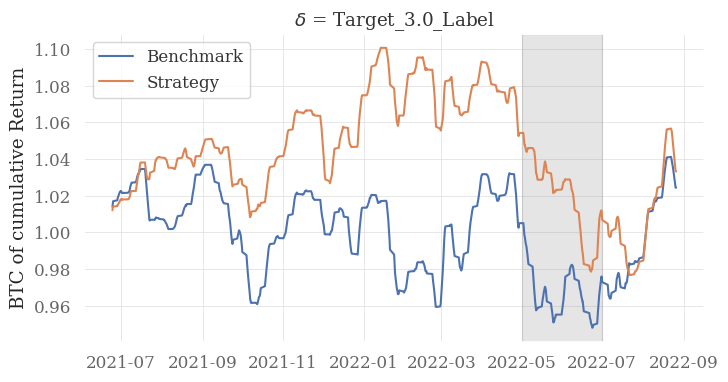

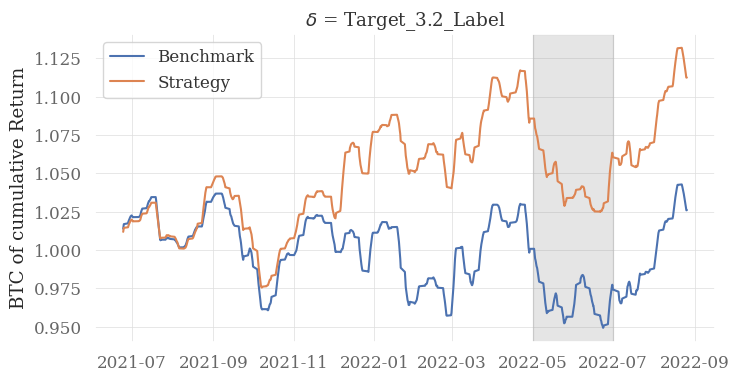

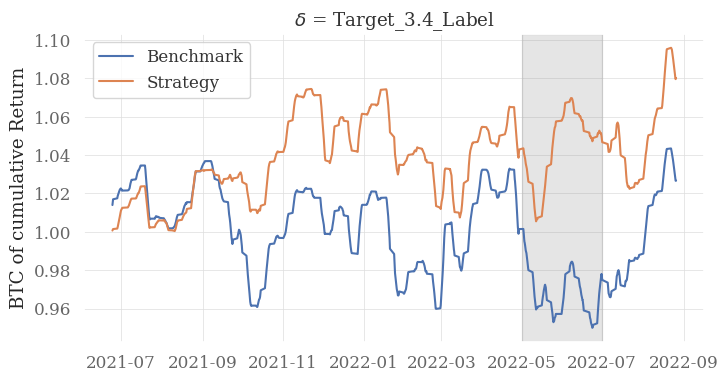

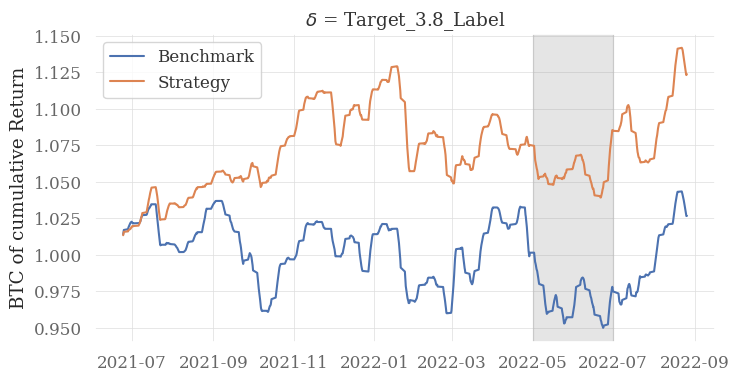

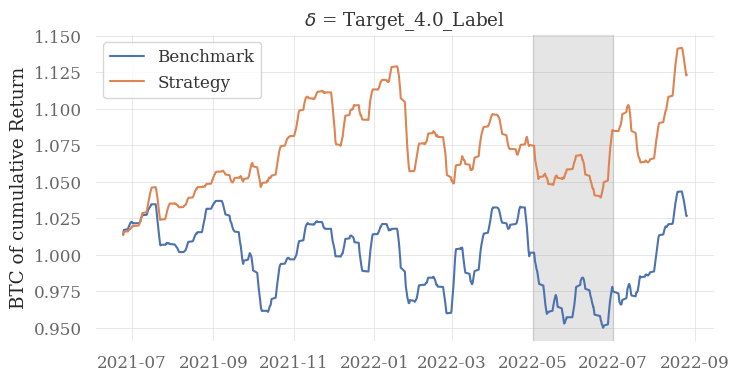

In [172]:
origin, pct = get_pct_and_our_data("YM_4h", "knn") # get_pct_and_our_data("YM_4h", "knn")  ata("NQ_4h", "knn") ("ES_4h", "knn") 
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

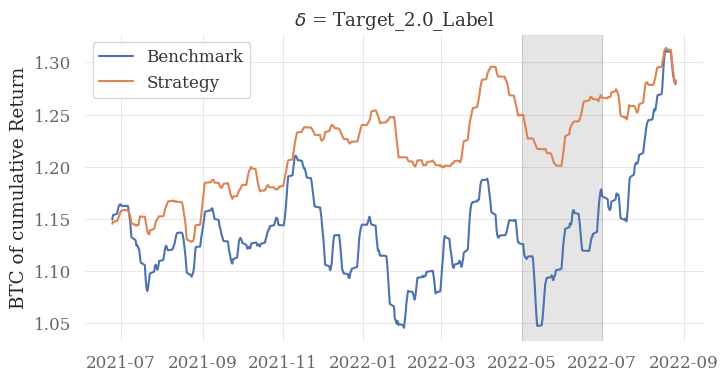

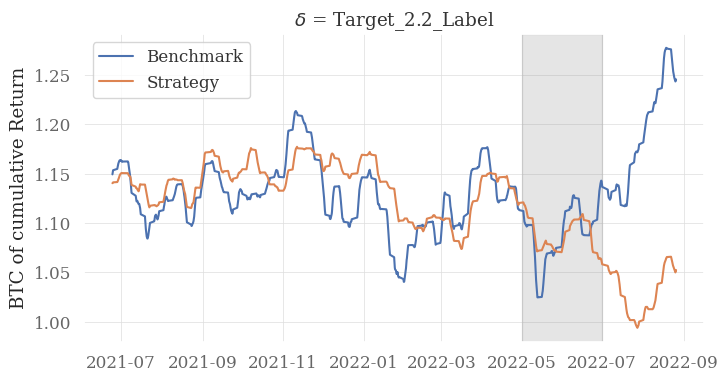

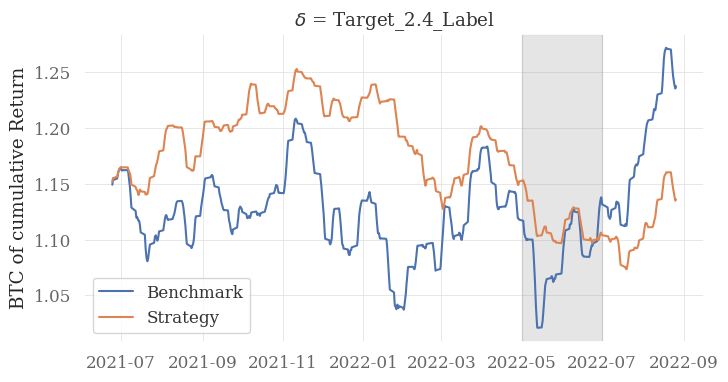

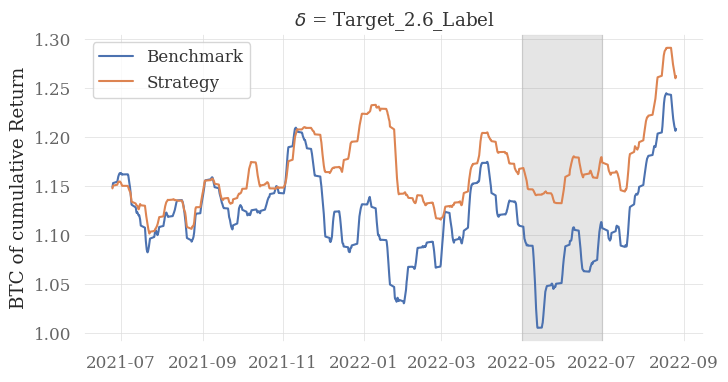

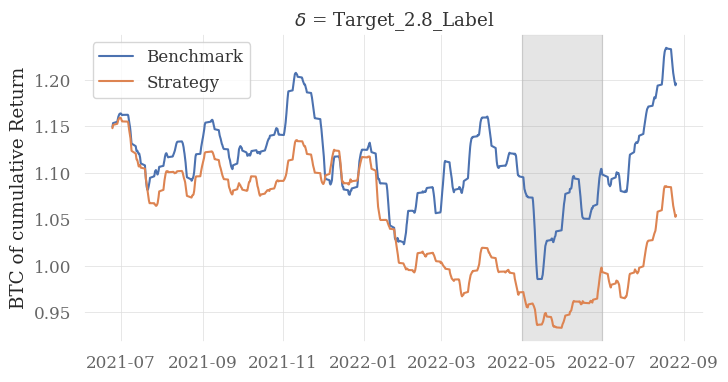

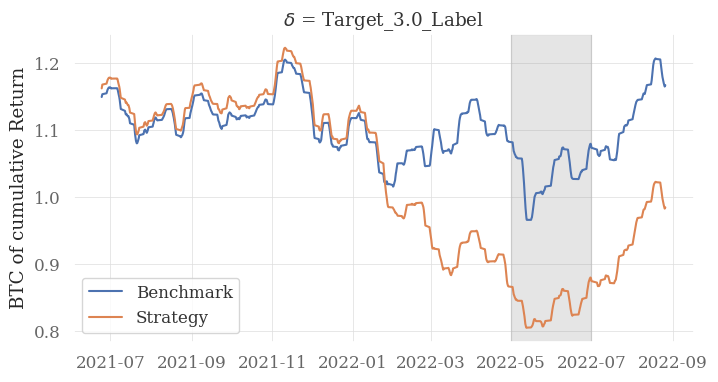

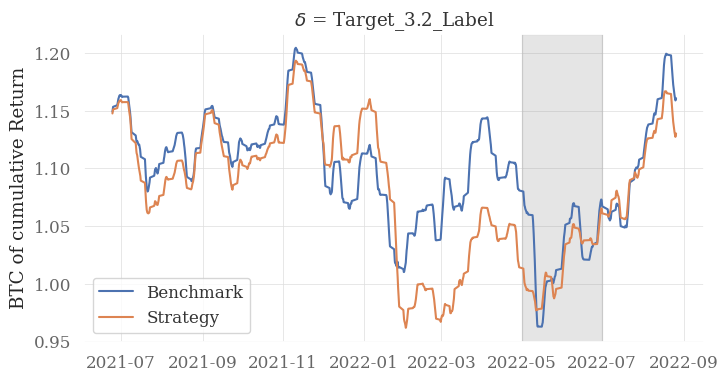

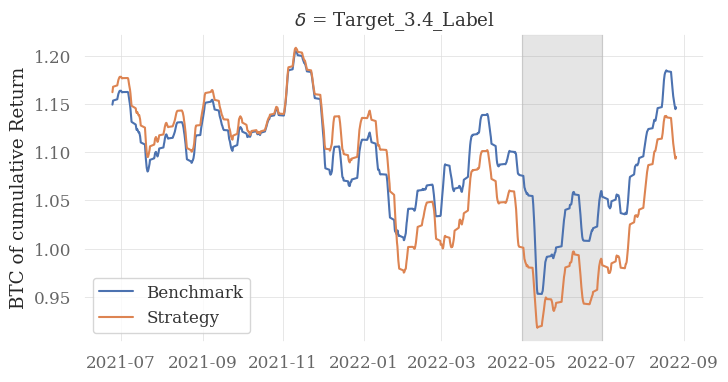

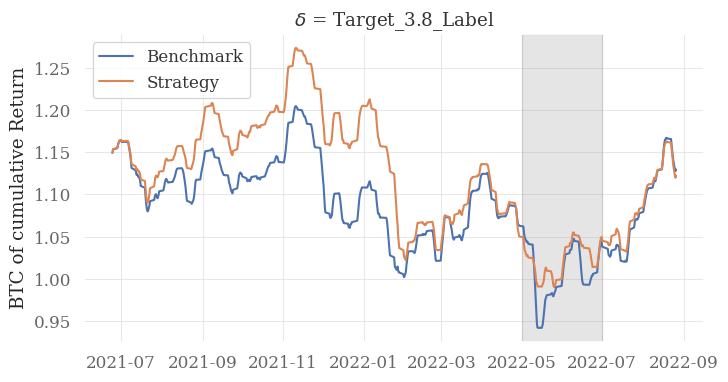

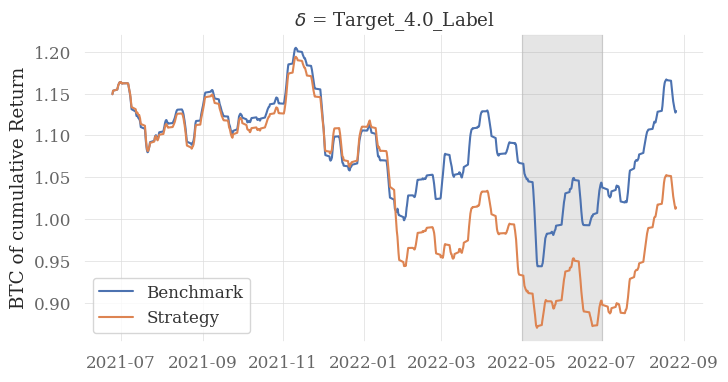

In [166]:
origin, pct = get_pct_and_our_data("RTY_4h", "cat") # cat ata("RTY_4h", "cat") # cat
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

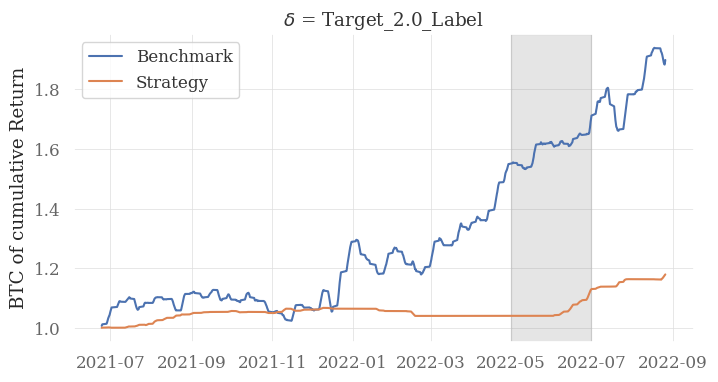

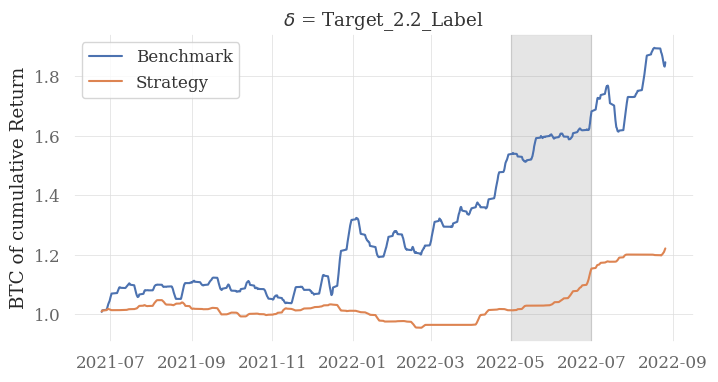

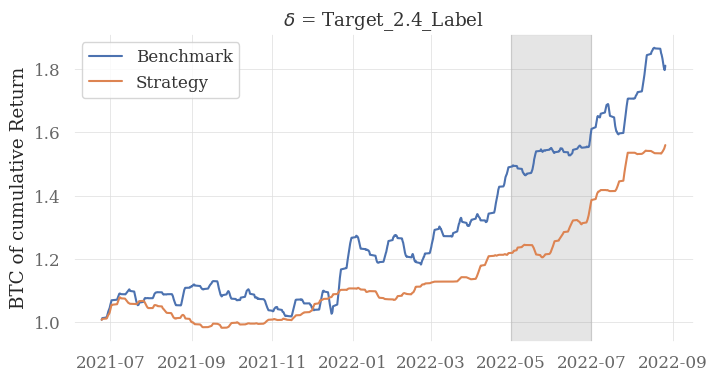

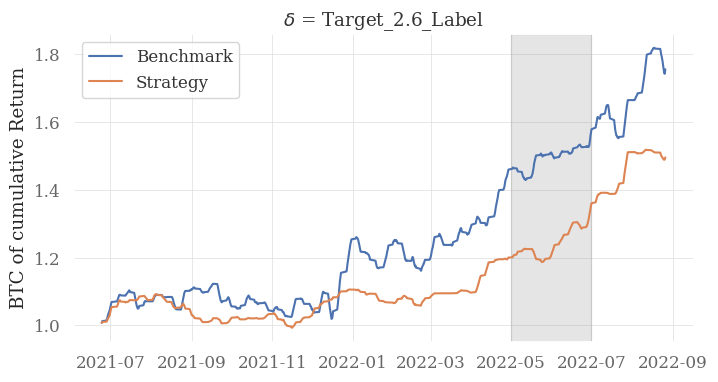

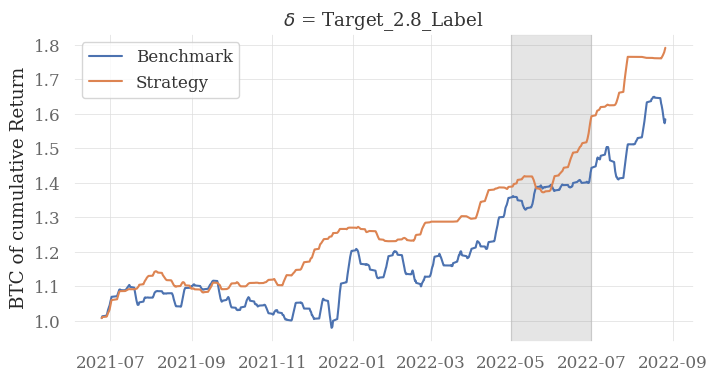

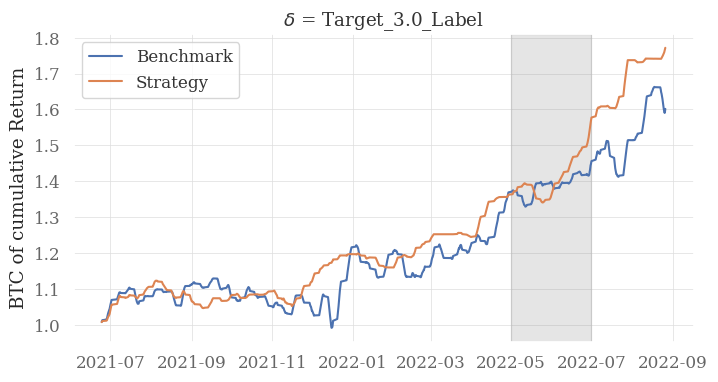

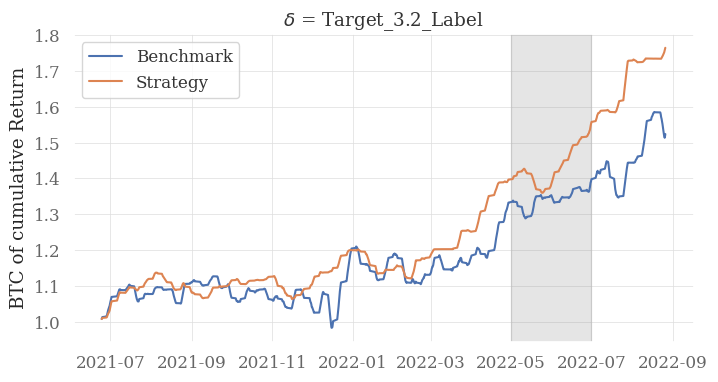

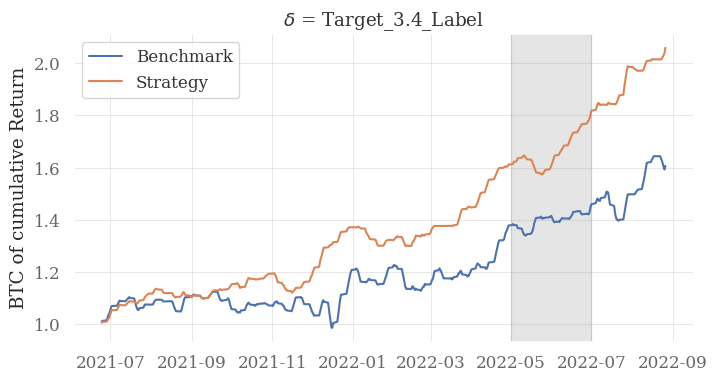

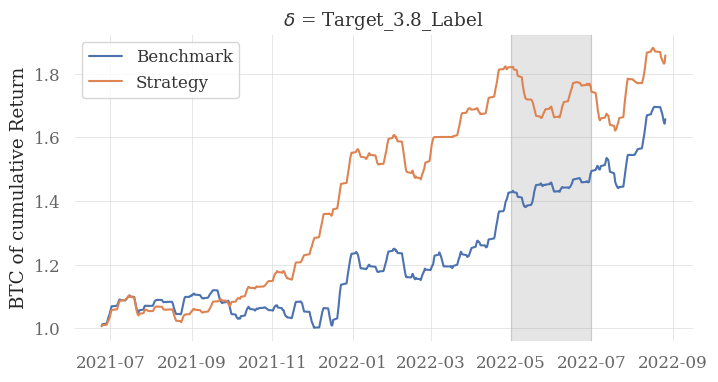

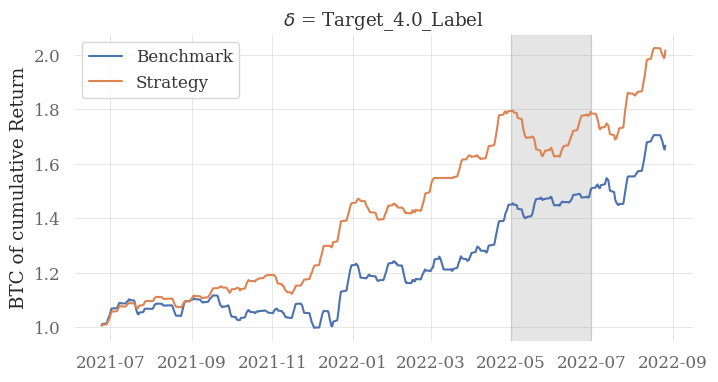

In [174]:
origin, pct = get_pct_and_our_data("PA_4h", "mlp") 
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

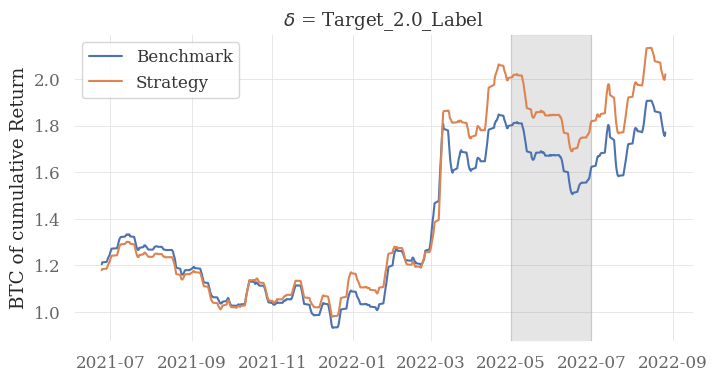

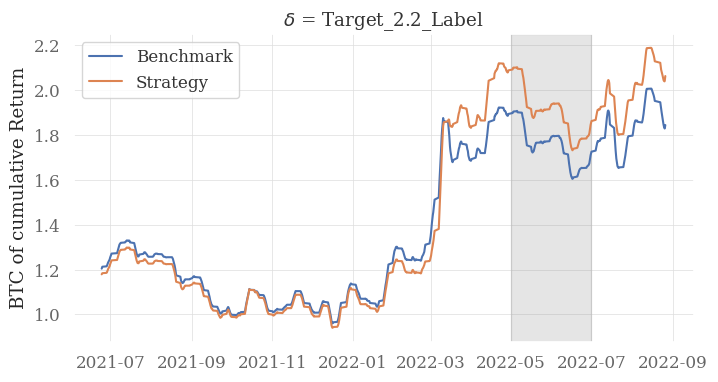

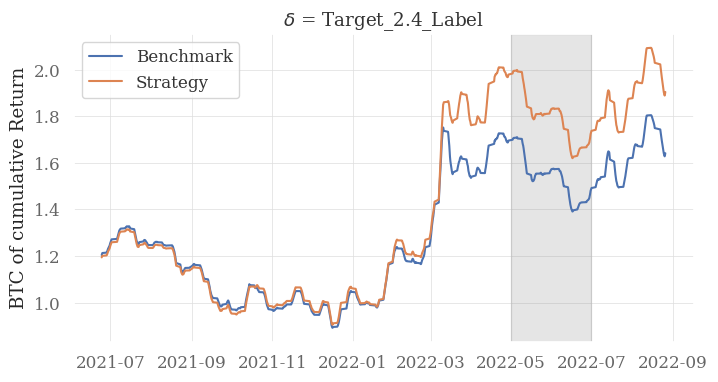

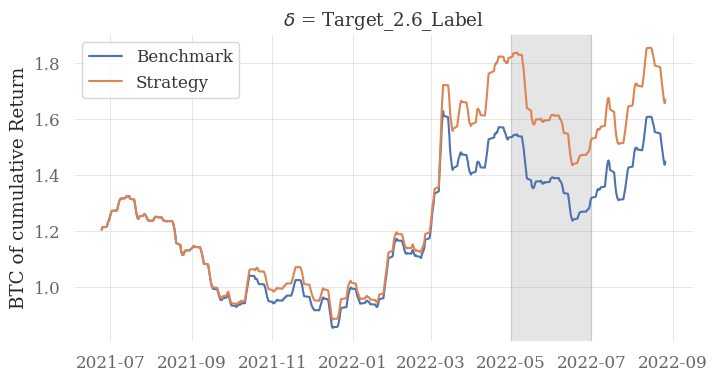

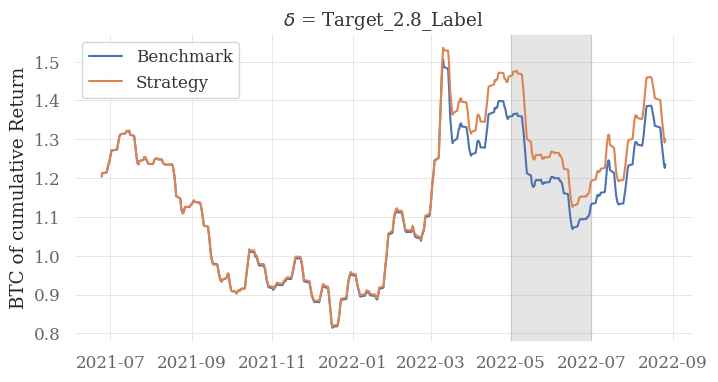

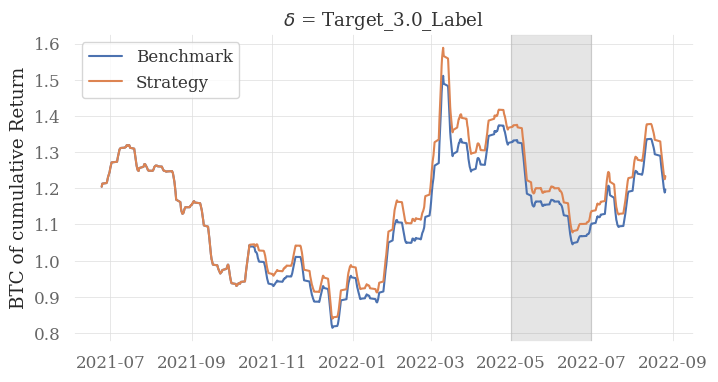

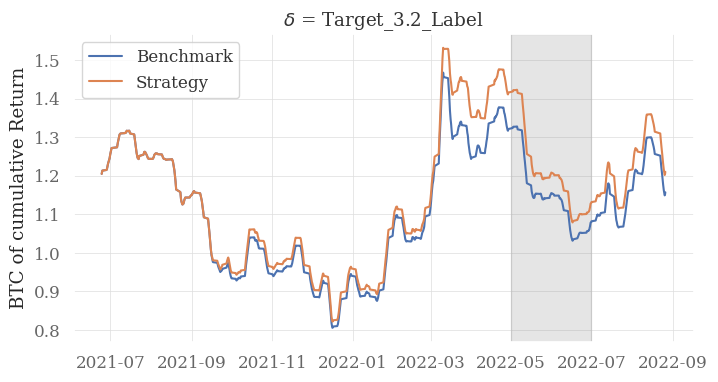

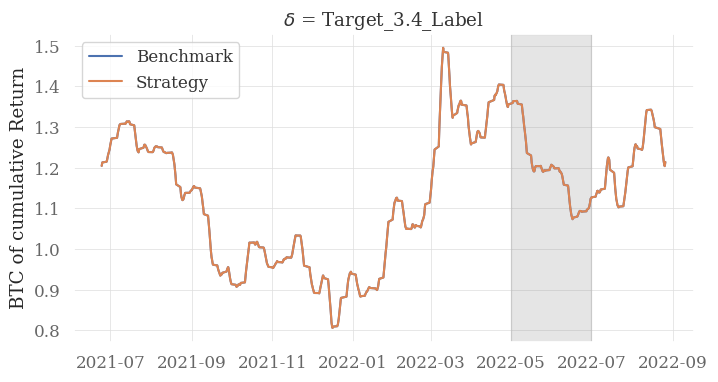

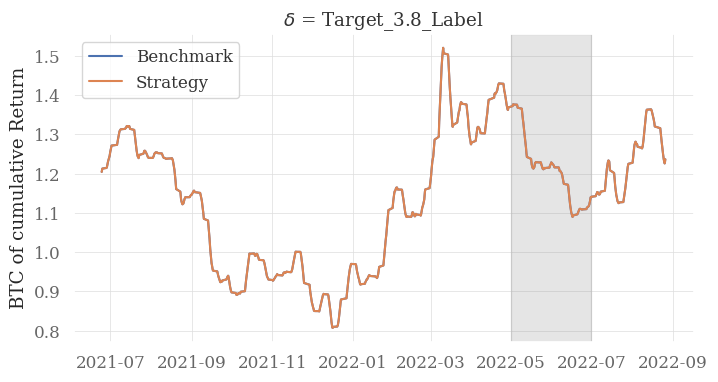

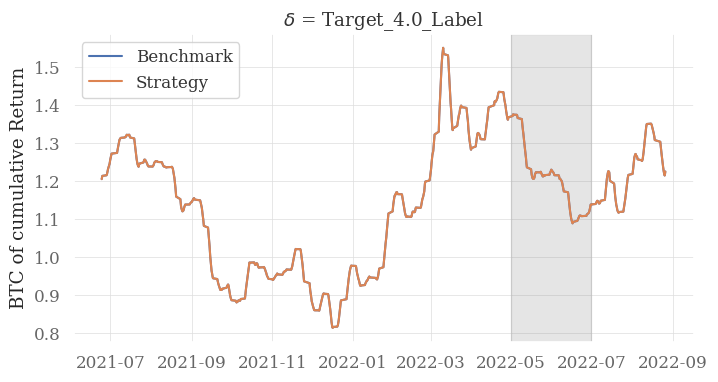

In [177]:
origin, pct = get_pct_and_our_data("PA_4h", "xg") 
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

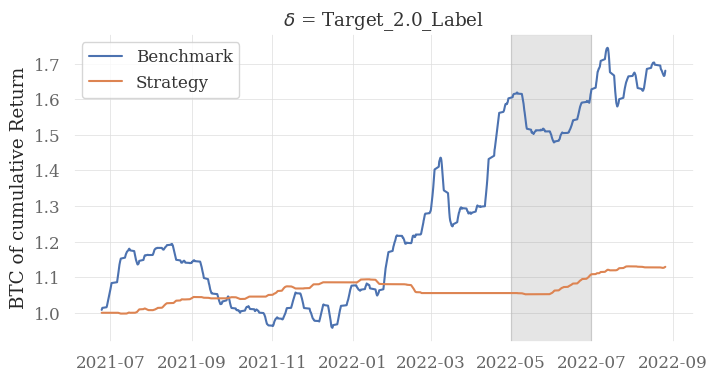

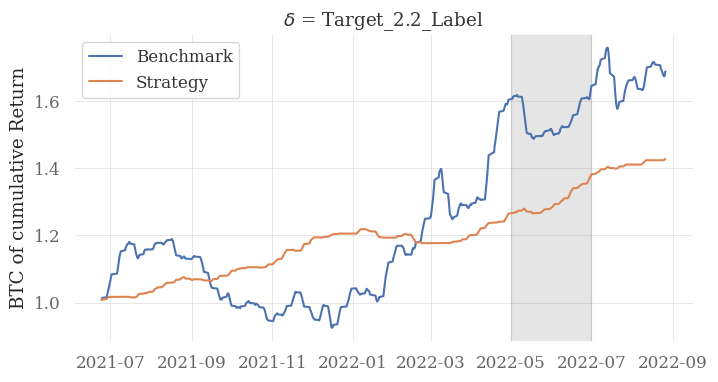

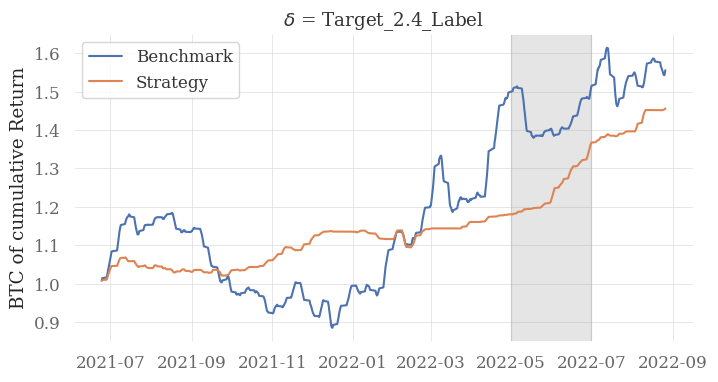

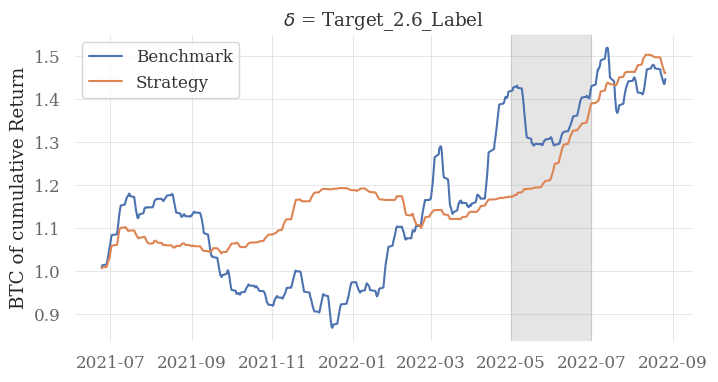

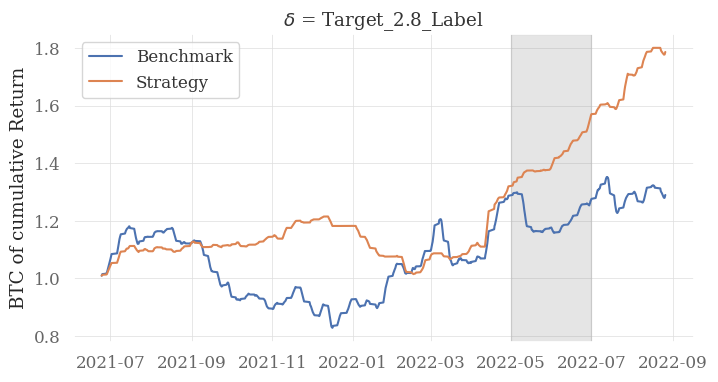

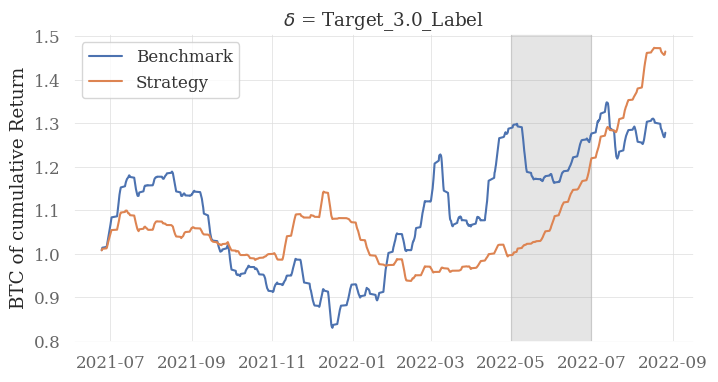

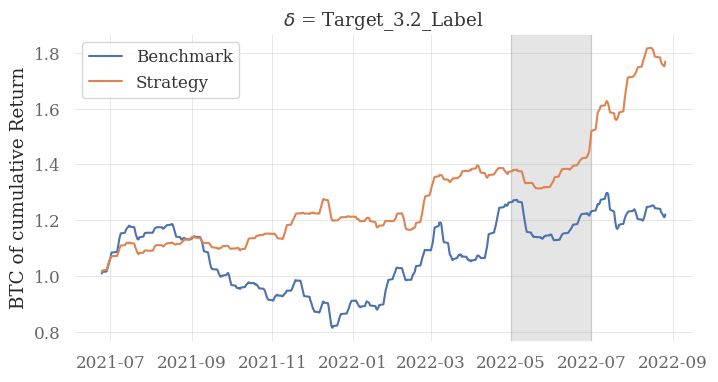

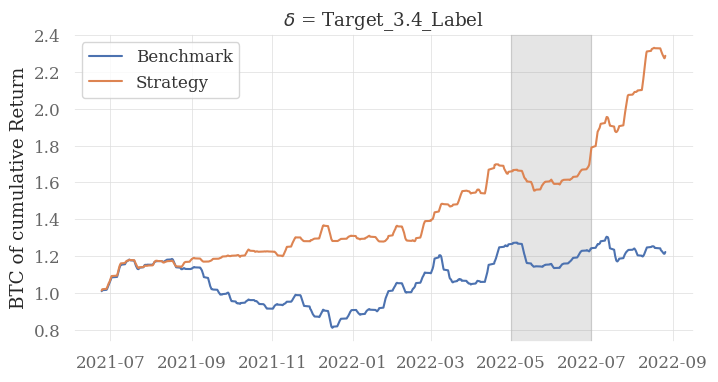

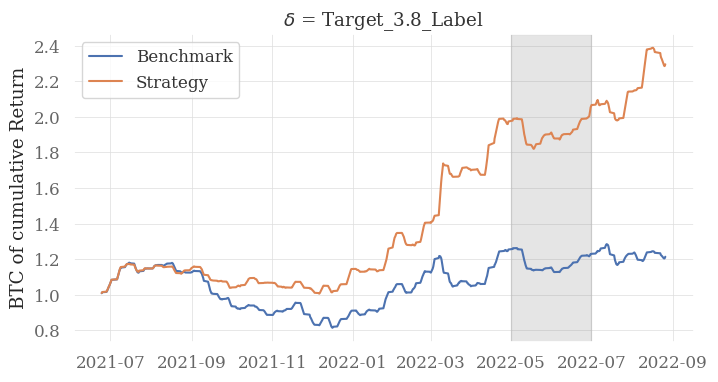

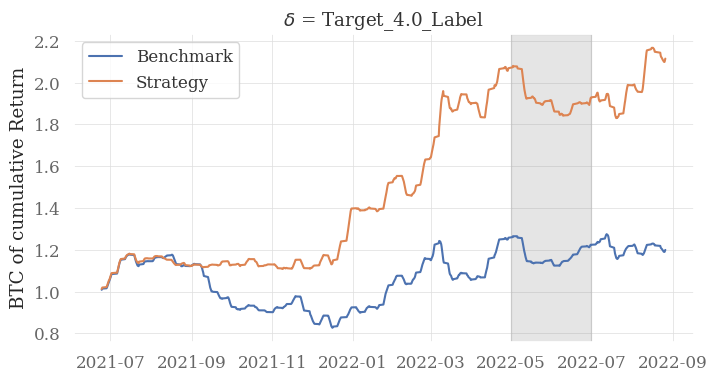

In [178]:
origin, pct = get_pct_and_our_data("PA_4h", "cat") 
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")

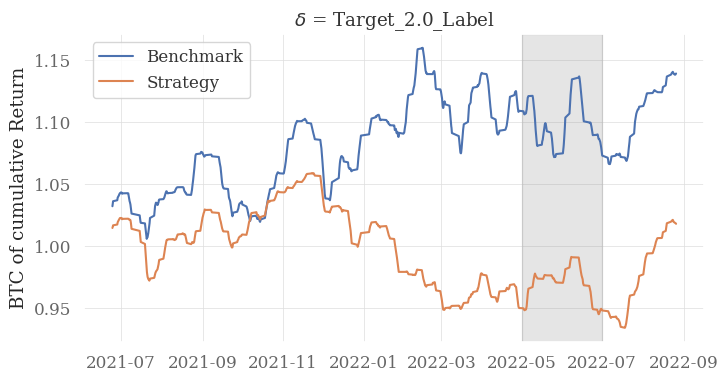

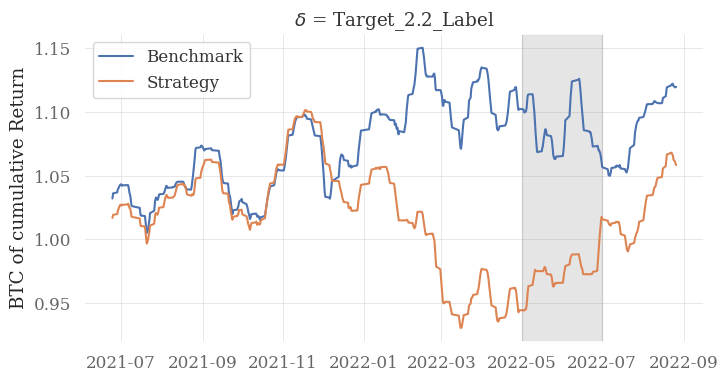

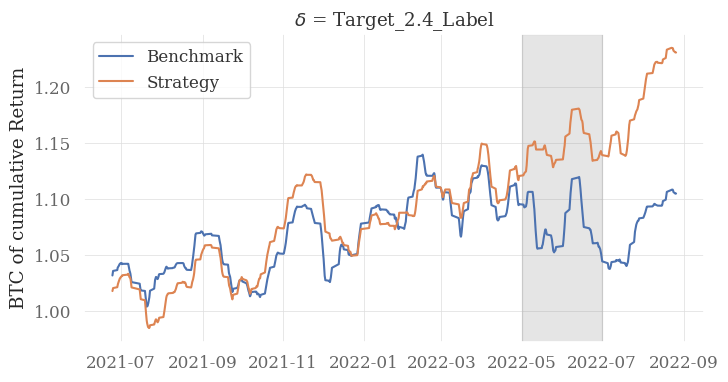

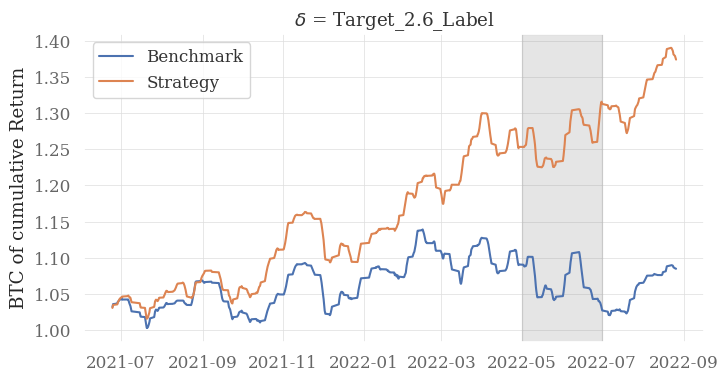

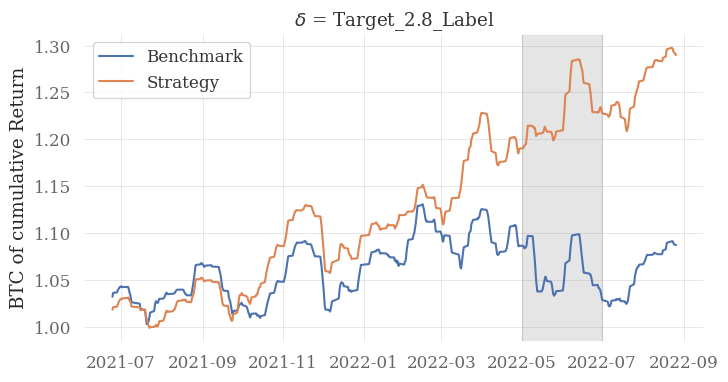

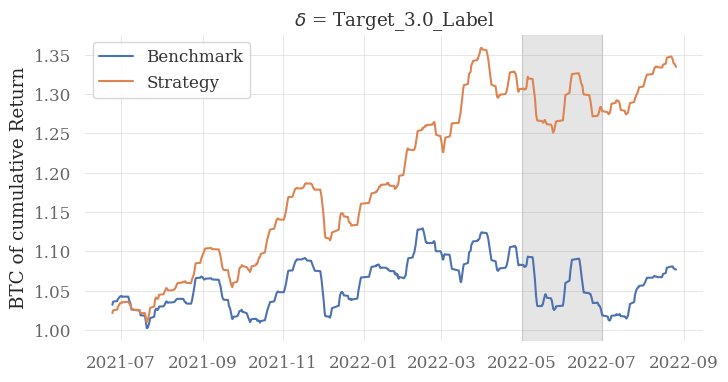

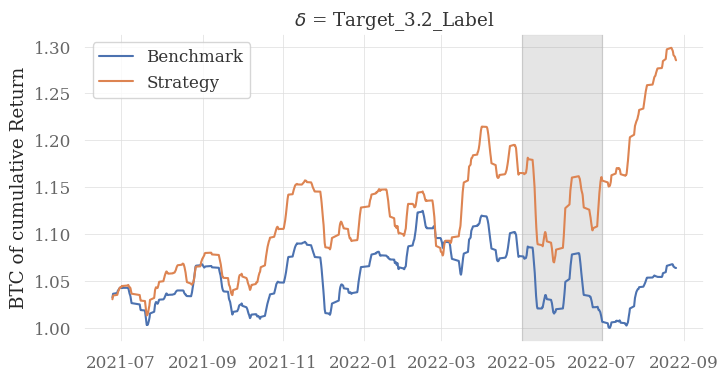

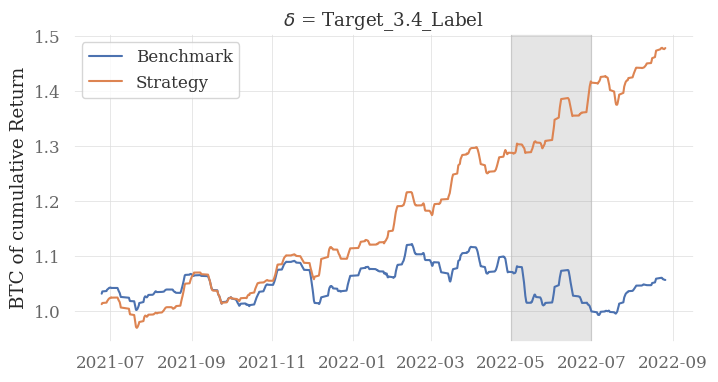

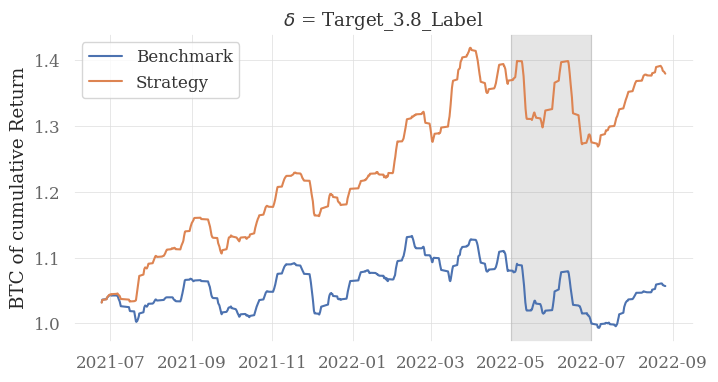

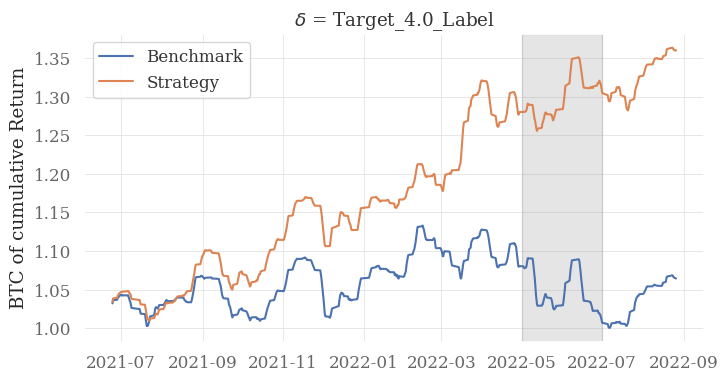

In [165]:
origin, pct = get_pct_and_our_data("EW_4h", "rf") # cat get_pct_and_our_data("PA_4h", "rf"
plot_return(origin, pct, "Target_2.0_Label", "Target_2.0post_Label")
plot_return(origin, pct, "Target_2.2_Label", "Target_2.2post_Label")
plot_return(origin, pct, "Target_2.4_Label", "Target_2.4post_Label")
plot_return(origin, pct, "Target_2.6_Label", "Target_2.6post_Label")
plot_return(origin, pct, "Target_2.8_Label", "Target_2.8post_Label")
plot_return(origin, pct, "Target_3.0_Label", "Target_3.0post_Label")
plot_return(origin, pct, "Target_3.2_Label", "Target_3.2post_Label")
plot_return(origin, pct, "Target_3.4_Label", "Target_3.4post_Label")
plot_return(origin, pct, "Target_3.8_Label", "Target_3.8post_Label")
plot_return(origin, pct, "Target_4.0_Label", "Target_4.0post_Label")